# ZL+vMIT Hybrid EOS Notebook

This notebook generates hybrid EOS tables with a hadron-quark phase transition.
- Zero and finite temperature
- Beta equilibrium and fixed Y_C (or equivally Y_e)

## Physical Content

- **Hadronic phase (H):** ZL model with nucleons (proton, neutron)
- **Quark phase (Q):** vMIT bag model with u, d, s quarks
- **Mixed phase:** Global eletric charge neutrality (η=0), Local electric charge neutrality (η=1), or intermediate (0<η<1) construction
- **Equilibrium modes:** β-equilibrium or fixed charge fraction Y_C

## Notebook Structure

1. **Input Parameters** - Define grids and model parameters
2. **Beta Equilibrium** - Compute EOS in beta_eq as a function of (n_B, T, η)
3. **Fixed Y_C** - Compute EOS at fixed Y_C as a function of (n_B, Y_C, T, η)
4. **Plots** - Visualization of results

##  Modules

| `zlvmit_mixed_phase_eos.py` | Core solvers and table generation |
| `zl_compute_tables.py` | Pure hadronic phase tables |
| `vmit_compute_tables.py` | Pure quark phase tables |
| `zlvmit_table_reader.py` | Load and interpolate EOS tables |
| `zlvmit_plot_results.py` | Plotting utilities |

## Output Files 

- `pure_H_table_*.dat` - Pure hadronic phase table
- `pure_Q_table_*.dat` - Pure quark phase table  
- `table_hybrid_*_result.dat` - Primary output (only conserved charges)
- `table_hybrid_*_complete.dat` - Complete thermodynamic quantities output
- `boundaries_*.dat` - Phase transition boundaries

---

In [1]:
# =============================================================================
# IMPORT
# =============================================================================

# Import
import numpy as np
import os
from datetime import datetime

from eos.zl.parameters import get_zl_default
from eos.vmit.parameters import VMITParams, get_vmit_custom
from eos.zlvmit.mixed_phase_eos import (
    get_or_compute_boundaries, 
    generate_unified_table,
    results_to_dict_primary, 
    results_to_dict_complete, 
    save_table_full
)
from eos.zl.compute_tables import ZLTableSettings, compute_zl_table
from eos.vmit.compute_tables import VMITTableSettings, compute_vmit_table
from eos.zlvmit.plot_results import (
    plot_betaeq, 
    plot_fixedyc, 
    plot_composition, 
    plot_mixed_phase_boundaries,
    setup_matplotlib_style,
    ETA_STYLES,
    N_SAT,
)


import matplotlib.pyplot as plt

# Input Parameters

In [3]:
# =============================================================================
# INPUT PARAMETERS 
# =============================================================================


# Density grid (fm^-3)
n0 = 0.16  # Nuclear saturation density
n_B_min = 0.1 * n0        
n_B_max = 12.0 * n0        
n_B_steps = 300           # Number of density points
n_B_values = np.linspace(n_B_min, n_B_max, n_B_steps)

# Temperature grid (MeV)
T_values = np.concatenate([[0, 0.1], np.arange(2.5, 121., 2.5)])

# Local/Global charge neutrality parameter η: 0 = GCN, 1 = LCN
eta_values = [0., 0.1, 0.3, 0.6, 1.0]

# Charge fractions (used in fixed YC case)
Y_C_values = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5] #np.size(np.arange(0.01, 0.50001, 0.01))

# vMIT bag model parameters
B4 = 180.0   # Bag constant B^{1/4} in MeV
a = 0.2      # Vector coupling in fm²
vmit_params = VMITParams(name=f"vMIT_B{int(B4)}_a{a}", B4=B4, a=a)

# ZL parameters
zl_params = get_zl_default() #default for parameters used in Constantinou et. al 2023 and 2025.

# Output directories (absolute paths)
from eos import REPO_ROOT
DIR = str(REPO_ROOT / "output" / "zlvmit_eos")
os.makedirs(DIR, exist_ok=True)

# Control flags
VERBOSE = True                       # Print detailed progress
FORCE_RECOMPUTE_BOUNDARIES = True   # Recompute boundaries if they exist

# Print configuration summary
print("=" * 70)
print("ZL + vMIT Hybrid EOS Configuration")
print("=" * 70)
print(f"  Density grid: [{n_B_min:.4f}, {n_B_max:.4f}] fm⁻³ ({n_B_steps} points)")
print(f"  Temperature grid: {len(T_values)} values from {T_values.min():.1f} to {T_values.max():.1f} MeV")
print(f"  η values: {eta_values}")
print(f"  vMIT parameters: B^(1/4) = {B4} MeV, a = {a} fm²")
print(f"  Output directory: {DIR}")
print("=" * 70)

ZL + vMIT Hybrid EOS Configuration
  Density grid: [0.0160, 1.9200] fm⁻³ (300 points)
  Temperature grid: 50 values from 0.0 to 120.0 MeV
  η values: [0.0, 0.1, 0.3, 0.6, 1.0]
  vMIT parameters: B^(1/4) = 180.0 MeV, a = 0.2 fm²
  Output directory: /Users/mircoguerrini/Desktop/Research/Python_codes/output/zlvmit_eos



# BETA EQUILIBRIUM 


## COMPUTE PURE PHASE TABLES (ZL and vMIT)

In [3]:
# =============================================================================
# STEP 1: COMPUTE PURE PHASE TABLES (ZL and vMIT)
# =============================================================================

print("\n" + "=" * 70)
print("STEP 1: Computing Pure Phase Tables")
print("=" * 70)

# ZL pure phase table settings
zl_settings = ZLTableSettings(
    params=zl_params,
    n_B_values=n_B_values,
    T_values=T_values,
    equilibrium='beta_eq',
    include_photons=True,
    print_results=VERBOSE,
    print_first_n=1
)

# vMIT pure phase table settings  
vmit_settings = VMITTableSettings(
    params=vmit_params,
    n_B_values=n_B_values,
    T_values=T_values,
    equilibrium='beta_eq',
    include_photons=True,
    print_results=VERBOSE,
    print_first_n=1
)

# Compute ZL table
print("Computing ZL pure phase table...")
zl_table_by_T = compute_zl_table(zl_settings)
print(f"ZL table: {len(zl_table_by_T)} temperature points computed")

# Compute vMIT table
print("Computing vMIT pure phase table...")
vmit_table_by_T = compute_vmit_table(vmit_settings)
print(f"vMIT table: {len(vmit_table_by_T)} temperature points computed")

# Convert _table_by_T[(T),results]->_table[(n_B, T),results] lookup format needed for boundary finder
zl_table = {}
for key, results in zl_table_by_T.items():
    T = key[0]  # key is (T,) for beta_eq
    for i, r in enumerate(results):
        if r.converged:
            zl_table[(n_B_values[i], T)] = r

vmit_table = {}
for key, results in vmit_table_by_T.items():
    T = key[0]  # key is (T,) for beta_eq
    for i, r in enumerate(results):
        if r.converged:
            vmit_table[(n_B_values[i], T)] = r

print(f"Converted: {len(zl_table)} ZL points, {len(vmit_table)} vMIT points")

# Save pure phase tables
print("\nSaving pure phase tables...")

# Save as .dat with selected columns

# Convert _table_by_T[(T),results]->_results[results] for table writing
zl_results = [r for results in zl_table_by_T.values() for r in results]
vmit_results = [r for results in vmit_table_by_T.values() for r in results]

# ZL columns
zl_dat = {'nB': [], 'T': [], 'converged': [], 'error': [], 'mu_p_H': [], 'mu_n_H': [], 'n_p_H': [], 'n_n_H': [], 
          'mu_eL_H': [], 'n_eL_H': [], 'P_total': [], 'e_total': [], 's_total': [], 'f_total': [], 
          'Y_p_H': [], 'Y_n_H': [], 'Y_C_H': [], 'Y_S_H': [], 'Y_eL_H': []}

for r in zl_results:
    zl_dat['nB'].append(r.n_B)
    zl_dat['T'].append(r.T)
    zl_dat['converged'].append(r.converged)
    zl_dat['error'].append(r.error)
    zl_dat['mu_p_H'].append(r.mu_p)
    zl_dat['mu_n_H'].append(r.mu_n)
    zl_dat['n_p_H'].append(r.n_p)
    zl_dat['n_n_H'].append(r.n_n)
    zl_dat['mu_eL_H'].append(r.mu_e)
    zl_dat['n_eL_H'].append(r.n_e)
    zl_dat['P_total'].append(r.P_total)
    zl_dat['e_total'].append(r.e_total)
    zl_dat['s_total'].append(r.s_total)
    zl_dat['f_total'].append(r.e_total - r.T * r.s_total)
    zl_dat['Y_p_H'].append(r.Y_p)
    zl_dat['Y_n_H'].append(r.Y_n)
    zl_dat['Y_C_H'].append(r.Y_p)
    zl_dat['Y_S_H'].append(0.0)
    zl_dat['Y_eL_H'].append(r.Y_e)

# vMIT columns
vmit_dat = {'nB': [], 'T': [], 'converged': [], 'error': [], 'mu_u_Q': [], 'mu_d_Q': [], 'mu_s_Q': [], 
            'n_u_Q': [], 'n_d_Q': [], 'n_s_Q': [], 'mu_eL_Q': [], 'n_eL_Q': [], 'P_total': [], 'e_total': [], 
            's_total': [], 'f_total': [], 'Y_u_Q': [], 'Y_d_Q': [], 'Y_s_Q': [], 'Y_C_Q': [], 'Y_S_Q': [], 'Y_eL_Q': []}

for r in vmit_results:
    vmit_dat['nB'].append(r.n_B)
    vmit_dat['T'].append(r.T)
    vmit_dat['converged'].append(r.converged)
    vmit_dat['error'].append(r.error)
    vmit_dat['mu_u_Q'].append(r.mu_u)
    vmit_dat['mu_d_Q'].append(r.mu_d)
    vmit_dat['mu_s_Q'].append(r.mu_s)
    vmit_dat['n_u_Q'].append(r.n_u)
    vmit_dat['n_d_Q'].append(r.n_d)
    vmit_dat['n_s_Q'].append(r.n_s)
    vmit_dat['mu_eL_Q'].append(r.mu_e)
    vmit_dat['n_eL_Q'].append(r.n_e)
    vmit_dat['P_total'].append(r.P_total)
    vmit_dat['e_total'].append(r.e_total)
    vmit_dat['s_total'].append(r.s_total)
    vmit_dat['f_total'].append(r.e_total - r.T * r.s_total)
    vmit_dat['Y_u_Q'].append(r.Y_u)
    vmit_dat['Y_d_Q'].append(r.Y_d)
    vmit_dat['Y_s_Q'].append(r.Y_s)
    vmit_dat['Y_C_Q'].append(2/3 * r.Y_u - 1/3 * r.Y_d - 1/3 * r.Y_s)
    vmit_dat['Y_S_Q'].append(r.Y_s)
    vmit_dat['Y_eL_Q'].append(r.Y_e)

save_table_full(zl_dat, os.path.join(DIR, f"pure_H_table_beta.dat"), f"ZL pure H, beta eq")
save_table_full(vmit_dat, os.path.join(DIR, f"pure_Q_table_beta_B{int(B4)}_a{a}.dat"), f"vMIT pure Q, beta eq, B^1/4={B4} MeV")



STEP 1: Computing Pure Phase Tables
Computing ZL pure phase table...
ZL EOS TABLE GENERATION

Model: ZL_Constantinou
Equilibrium: beta_eq
Density grid: 300 points, n_B = [1.6000e-02, 1.9200e+00] fm⁻³
Parameter grid: 50 tables

----------------------------------------------------------------------
[1/50] T=0.0
[   0] n_B=1.6000e-02 [OK] P=0.0372 Y_p=0.0079 err=9.48e-25

  0.05s (0.2ms/pt), Converged: 300/300 (100.0%)
----------------------------------------------------------------------
[2/50] T=0.1
[   0] n_B=1.6000e-02 [OK] P=0.0372 Y_p=0.0079 err=5.37e-20

  0.30s (1.0ms/pt), Converged: 300/300 (100.0%)
----------------------------------------------------------------------
[3/50] T=2.5
[   0] n_B=1.6000e-02 [OK] P=0.0488 Y_p=0.0132 err=1.92e-22

  0.34s (1.1ms/pt), Converged: 300/300 (100.0%)
----------------------------------------------------------------------
[4/50] T=5.0
[   0] n_B=1.6000e-02 [OK] P=0.0760 Y_p=0.0227 err=2.43e-26

  0.44s (1.5ms/pt), Converged: 300/300 (100.0%)


## COMPUTE PHASE BOUNDARIES FOR EACH η

In [4]:

# =============================================================================
# STEP 2: COMPUTE PHASE BOUNDARIES FOR EACH η
# =============================================================================

print("\n" + "=" * 70)
print("STEP 2: Computing Phase Boundaries")
print("=" * 70)

boundaries = {}
for eta in eta_values:
    print(f"Computing boundaries for η = {eta}")
    boundaries[eta] = get_or_compute_boundaries(
        eta=eta,
        T_values=T_values,
        zl_params=zl_params,
        vmit_params=vmit_params,
        output_dir=DIR,
        force_recompute=FORCE_RECOMPUTE_BOUNDARIES,
        verbose=VERBOSE,
        H_table_lookup=zl_table,
        Q_table_lookup=vmit_table,
        return_dict=True  # Returns dict format ready for generate_unified_table
    )
    print(f"  Found {len(boundaries[eta])} boundary points")



STEP 2: Computing Phase Boundaries
Computing boundaries for η = 0.0
Computing boundaries for η=0.00 [beta]...

--- Onset (χ=0, η=0.00) ---
    Trying T=40.0 n_B_est=0.6237: guess μp=1094.9 μn=1385.4 μu=268.2 μd=558.6 μs=558.6 μeG=290.4 np=0.1278 nn=0.4958
  Found working start: T=40.0 MeV, n_B_est=0.6237, n_B=0.4293
  ✓ T= 40.00 n_B=0.4293 μp=915.9 μn=1129.8 μu=234.0 μd=447.9 μs=447.9 μeH=0.0 μeQ=0.0 μeG=213.9 np=0.0579 nn=0.3714 nu=0.1013 nd=0.8310 ns=0.6670 (err=3.4e-10)
  ✓ T= 42.50 n_B=0.4223 μp=906.0 μn=1117.8 μu=231.4 μd=443.2 μs=443.2 μeH=0.0 μeQ=0.0 μeG=211.8 np=0.0583 nn=0.3639 nu=0.1035 nd=0.8180 ns=0.6559 (err=2.0e-12)
  ✓ T= 45.00 n_B=0.4148 μp=895.7 μn=1105.1 μu=228.8 μd=438.2 μs=438.2 μeH=0.0 μeQ=0.0 μeG=209.4 np=0.0588 nn=0.3560 nu=0.1059 nd=0.8044 ns=0.6443 (err=3.8e-10)
  ✓ T= 47.50 n_B=0.4066 μp=884.9 μn=1091.7 μu=226.0 μd=432.9 μs=432.9 μeH=0.0 μeQ=0.0 μeG=206.8 np=0.0591 nn=0.3475 nu=0.1085 nd=0.7902 ns=0.6322 (err=8.0e-10)
  ✓ T= 50.00 n_B=0.3979 μp=873.7 μn=1077.

# GENERATE UNIFIED HYBRID EOS TABLES and save

In [5]:

# =============================================================================
# STEP 3: GENERATE UNIFIED HYBRID EOS TABLES
# =============================================================================

print("\n" + "=" * 70)
print("STEP 3: Generating Unified Hybrid EOS Tables")
print("=" * 70)

hybrid_tables = {}
for eta in eta_values:
    print(f"Generating hybrid table for η = {eta}")
    unified_table = generate_unified_table(
        n_B_values=n_B_values,
        T_values=T_values,
        eta=eta,
        zl_params=zl_params,
        vmit_params=vmit_params,
        H_table=zl_table,
        Q_table=vmit_table,
        boundaries=boundaries[eta],
        verbose=VERBOSE
    )
    hybrid_tables[eta] = unified_table
    print(f"  Generated table with {len(unified_table)} total points")

# =============================================================================
# STEP 4: SAVE RESULTS TO FILES
# =============================================================================

print("\n" + "=" * 70)
print("STEP 4: Saving Results")
print("=" * 70)

for eta, table in hybrid_tables.items():
    filename_base = f"table_hybrid_betaeq_eta{eta:.2f}_B{int(B4)}_a{a}"
    header = f"ZL+vMIT hybrid EOS, eta={eta}, B^1/4={B4} MeV, a={a} fm^2, beta_eq"
    save_table_full(results_to_dict_primary(table, eta_override=eta), os.path.join(DIR, f"{filename_base}_result.dat"), header)
    save_table_full(results_to_dict_complete(table, eta_override=eta), os.path.join(DIR, f"{filename_base}_complete.dat"), header)

print("\n" + "=" * 70)
print("HYBRID EOS COMPUTATION COMPLETE")
print(f"Results saved to: {DIR}")
print("=" * 70)





STEP 3: Generating Unified Hybrid EOS Tables
Generating hybrid table for η = 0.0
  Assembling unified table [beta]...
    T=0.0: n_on=0.4805, n_off=1.7802 → 73 H, 205 mixed (100.0%), 22 Q  [0.10s, 0.3ms/pt]
    T=0.1: n_on=0.4806, n_off=1.7802 → 73 H, 205 mixed (100.0%), 22 Q  [0.52s, 1.7ms/pt]
    T=2.5: n_on=0.4804, n_off=1.7798 → 73 H, 204 mixed (100.0%), 23 Q  [0.68s, 2.3ms/pt]
    T=5.0: n_on=0.4799, n_off=1.7786 → 73 H, 204 mixed (100.0%), 23 Q  [0.78s, 2.6ms/pt]
    T=7.5: n_on=0.4791, n_off=1.7767 → 73 H, 204 mixed (100.0%), 23 Q  [0.78s, 2.6ms/pt]
    T=10.0: n_on=0.4777, n_off=1.7740 → 73 H, 204 mixed (100.0%), 23 Q  [0.78s, 2.6ms/pt]
    T=12.5: n_on=0.4760, n_off=1.7705 → 73 H, 203 mixed (100.0%), 24 Q  [0.78s, 2.6ms/pt]
    T=15.0: n_on=0.4738, n_off=1.7662 → 72 H, 203 mixed (100.0%), 25 Q  [0.79s, 2.6ms/pt]
    T=17.5: n_on=0.4712, n_off=1.7611 → 72 H, 203 mixed (100.0%), 25 Q  [0.79s, 2.6ms/pt]
    T=20.0: n_on=0.4682, n_off=1.7552 → 72 H, 202 mixed (100.0%), 26 Q  [0.7

# Fixed YC

## COMPUTE ALL PURE PHASE TABLES FOR ALL Y_C VALUES

In [6]:
# -------------------------------------------------------------------------
# STEP 1: COMPUTE ALL PURE PHASE TABLES FOR ALL Y_C VALUES
# -------------------------------------------------------------------------

print("\n" + "=" * 70)
print("STEP 1: Computing Pure Phase Tables for all Y_C values")
print("=" * 70)

# Storage for all pure phase tables
all_H_tables_yc = {}
all_Q_tables_yc = {}

# Storage for unified tables
zl_dat_all = {'nB': [], 'Y_C': [], 'T': [], 'converged': [], 'error': [], 'mu_p_H': [], 'mu_n_H': [], 
              'n_p_H': [], 'n_n_H': [], 'mu_eL_H': [], 'n_eL_H': [], 'P_total': [], 'e_total': [], 
              's_total': [], 'f_total': [], 'Y_p_H': [], 'Y_n_H': [], 'Y_C_H': [], 'Y_S_H': [], 'Y_eL_H': []}

vmit_dat_all = {'nB': [], 'Y_C': [], 'T': [], 'converged': [], 'error': [], 'mu_u_Q': [], 'mu_d_Q': [], 'mu_s_Q': [], 
                'n_u_Q': [], 'n_d_Q': [], 'n_s_Q': [], 'mu_eL_Q': [], 'n_eL_Q': [], 'P_total': [], 'e_total': [], 
                's_total': [], 'f_total': [], 'Y_u_Q': [], 'Y_d_Q': [], 'Y_s_Q': [], 'Y_C_Q': [], 'Y_S_Q': [], 'Y_eL_Q': []}


# ZL pure phase table settings
zl_settings = ZLTableSettings(
    params=zl_params,
    n_B_values=n_B_values,
    T_values=T_values,
    equilibrium='fixed_yc',
    Y_C_values=Y_C_values,
    include_photons=True,
    print_results=VERBOSE,
    print_first_n=1
    )
    
# vMIT pure phase table settings
vmit_settings = VMITTableSettings(
    params=vmit_params,
    n_B_values=n_B_values,
    T_values=T_values,
    equilibrium='fixed_yc',
    Y_C_values=Y_C_values,
    include_photons=True,
    print_results=VERBOSE,
    print_first_n=1
    )
    
# Compute ZL table
print(f"Computing ZL pure phase")
zl_table_by_YC_T = compute_zl_table(zl_settings)

# Compute vMIT table
print(f"Computing vMIT pure phase")
vmit_table_by_YC_T = compute_vmit_table(vmit_settings)

    
# Convert _table_by_YC_T[(T,Y_C),results] --> zl_table_yc[Y_C][(n_B, T),results] lookup format for boundaries computation
zl_table_yc = {}
 
for key, results in zl_table_by_YC_T.items():
    T = key[0]  
    Y_C = key[1]  # Extract Y_C from the key
    
    # Initialize nested dict for this Y_C if not exists
    if Y_C not in zl_table_yc:
        zl_table_yc[Y_C] = {}
    
    for i, r in enumerate(results):
        zl_table_yc[Y_C][(n_B_values[i], T)] = r
 
vmit_table_yc = {}
for key, results in vmit_table_by_YC_T.items():
    T = key[0]  
    Y_C = key[1]  # Extract Y_C from the key
    
    # Initialize nested dict for this Y_C if not exists
    if Y_C not in vmit_table_yc:
        vmit_table_yc[Y_C] = {}
    
    for i, r in enumerate(results):
        vmit_table_yc[Y_C][(n_B_values[i], T)] = r




# Save pure phase tables
print("\nSaving pure phase tables...")

# Convert  _table_by_YC_T[(T,Y_C),results] --> _results[results] for table writing
zl_results = [r for results in zl_table_by_YC_T.values() for r in results]
vmit_results = [r for results in vmit_table_by_YC_T.values() for r in results]

# ZL columns
zl_dat = {'nB': [], 'Y_C': [], 'T': [], 'converged': [], 'error': [], 'mu_p_H': [], 'mu_n_H': [], 'n_p_H': [], 'n_n_H': [], 
          'mu_eL_H': [], 'n_eL_H': [], 'P_total': [], 'e_total': [], 's_total': [], 'f_total': [], 
          'Y_p_H': [], 'Y_n_H': [], 'Y_C_H': [], 'Y_S_H': [], 'Y_eL_H': []}

for r in zl_results:
    zl_dat['nB'].append(r.n_B)
    zl_dat['Y_C'].append(r.Y_C)
    zl_dat['T'].append(r.T)
    zl_dat['converged'].append(r.converged)
    zl_dat['error'].append(r.error)
    zl_dat['mu_p_H'].append(r.mu_p)
    zl_dat['mu_n_H'].append(r.mu_n)
    zl_dat['n_p_H'].append(r.n_p)
    zl_dat['n_n_H'].append(r.n_n)
    zl_dat['mu_eL_H'].append(r.mu_e)
    zl_dat['n_eL_H'].append(r.n_e)
    zl_dat['P_total'].append(r.P_total)
    zl_dat['e_total'].append(r.e_total)
    zl_dat['s_total'].append(r.s_total)
    zl_dat['f_total'].append(r.e_total - r.T * r.s_total)
    zl_dat['Y_p_H'].append(r.Y_p)
    zl_dat['Y_n_H'].append(r.Y_n)
    zl_dat['Y_C_H'].append(r.Y_p)
    zl_dat['Y_S_H'].append(0.0)
    zl_dat['Y_eL_H'].append(r.Y_e)

# vMIT columns
vmit_dat = {'nB': [],'Y_C': [], 'T': [], 'converged': [], 'error': [], 'mu_u_Q': [], 'mu_d_Q': [], 'mu_s_Q': [], 
            'n_u_Q': [], 'n_d_Q': [], 'n_s_Q': [], 'mu_eL_Q': [], 'n_eL_Q': [], 'P_total': [], 'e_total': [], 
            's_total': [], 'f_total': [], 'Y_u_Q': [], 'Y_d_Q': [], 'Y_s_Q': [], 'Y_C_Q': [], 'Y_S_Q': [], 'Y_eL_Q': []}

for r in vmit_results:
    vmit_dat['nB'].append(r.n_B)
    vmit_dat['Y_C'].append(r.Y_C)
    vmit_dat['T'].append(r.T)
    vmit_dat['converged'].append(r.converged)
    vmit_dat['error'].append(r.error)
    vmit_dat['mu_u_Q'].append(r.mu_u)
    vmit_dat['mu_d_Q'].append(r.mu_d)
    vmit_dat['mu_s_Q'].append(r.mu_s)
    vmit_dat['n_u_Q'].append(r.n_u)
    vmit_dat['n_d_Q'].append(r.n_d)
    vmit_dat['n_s_Q'].append(r.n_s)
    vmit_dat['mu_eL_Q'].append(r.mu_e)
    vmit_dat['n_eL_Q'].append(r.n_e)
    vmit_dat['P_total'].append(r.P_total)
    vmit_dat['e_total'].append(r.e_total)
    vmit_dat['s_total'].append(r.s_total)
    vmit_dat['f_total'].append(r.e_total - r.T * r.s_total)
    vmit_dat['Y_u_Q'].append(r.Y_u)
    vmit_dat['Y_d_Q'].append(r.Y_d)
    vmit_dat['Y_s_Q'].append(r.Y_s)
    vmit_dat['Y_C_Q'].append(2/3 * r.Y_u - 1/3 * r.Y_d - 1/3 * r.Y_s)
    vmit_dat['Y_S_Q'].append(r.Y_s)
    vmit_dat['Y_eL_Q'].append(r.Y_e)

save_table_full(zl_dat, os.path.join(DIR, f"pure_H_table_fixedYC.dat"), f"ZL pure H, beta eq")
save_table_full(vmit_dat, os.path.join(DIR, f"pure_Q_table_fixedYC_B{int(B4)}_a{a}.dat"), f"vMIT pure Q, beta eq, B^1/4={B4} MeV")


STEP 1: Computing Pure Phase Tables for all Y_C values
Computing ZL pure phase
ZL EOS TABLE GENERATION

Model: ZL_Constantinou
Equilibrium: fixed_yc
Density grid: 300 points, n_B = [1.6000e-02, 1.9200e+00] fm⁻³
Parameter grid: 300 tables

----------------------------------------------------------------------
[1/300] T=0.0, Y_C=0.01
[   0] n_B=1.6000e-02 [OK] P=0.0368 Y_p=0.0100 err=6.24e-19

  0.07s (0.2ms/pt), Converged: 300/300 (100.0%)
----------------------------------------------------------------------
[2/300] T=0.0, Y_C=0.1
[   0] n_B=1.6000e-02 [OK] P=0.0345 Y_p=0.1000 err=9.26e-23

  0.05s (0.2ms/pt), Converged: 300/300 (100.0%)
----------------------------------------------------------------------
[3/300] T=0.0, Y_C=0.2
[   0] n_B=1.6000e-02 [OK] P=0.0526 Y_p=0.2000 err=1.02e-25

  0.05s (0.2ms/pt), Converged: 300/300 (100.0%)
----------------------------------------------------------------------
[4/300] T=0.0, Y_C=0.3
[   0] n_B=1.6000e-02 [OK] P=0.0862 Y_p=0.3000 err=6.43e

## COMPUTE PHASE BOUNDARIES FOR EACH η, Y_C

In [7]:
# =============================================================================
# STEP 2: COMPUTE PHASE BOUNDARIES FOR EACH η, Y_C
# =============================================================================

print("\n" + "=" * 70)
print("STEP 2: Computing Phase Boundaries")
print("=" * 70)

boundaries = {}
for Y_C in Y_C_values:
    print("\n" + "=" * 70)
    print("Computing Phase Boundaries for Y_C = ", Y_C)
    print("=" * 70) 
    boundaries_YC = {}
    for eta in eta_values:
        print(f"Computing boundaries for η = {eta}, Y_C = {Y_C}")
        boundaries_YC[eta] = get_or_compute_boundaries(
        eta=eta,
        eq_mode="fixed_yc", 
        Y_C=Y_C,
        T_values=T_values,
        zl_params=zl_params,
        vmit_params=vmit_params,
        output_dir=DIR,
        force_recompute=FORCE_RECOMPUTE_BOUNDARIES,
        verbose=True,
        H_table_lookup=zl_table_yc[Y_C],
        Q_table_lookup=vmit_table_yc[Y_C],
        return_dict=True 
    )
    boundaries[Y_C]=boundaries_YC



STEP 2: Computing Phase Boundaries

Computing Phase Boundaries for Y_C =  0.01
Computing boundaries for η = 0.0, Y_C = 0.01
Computing boundaries for η=0.00 [fixed_yc (Y_C=0.0100)]...

--- Onset (χ=0, η=0.00) ---
    Trying T=40.0 n_B_est=0.4271: guess μp=796.9 μn=1166.6 μu=142.4 μd=512.1 μs=512.1 μeG=52.4 np=0.0043 nn=0.4229
  Found working start: T=40.0 MeV, n_B_est=0.4271, n_B=0.1793
  ✓ T= 40.00 n_B=0.1793 μp=665.6 μn=944.6 μu=128.8 μd=407.9 μs=407.9 μeH=0.0 μeQ=0.0 μeG=24.9 np=0.0018 nn=0.1775 nu=0.0233 nd=0.6842 ns=0.5324 (err=4.6e-12)
  ✓ T= 42.50 n_B=0.1499 μp=645.2 μn=928.0 μu=120.8 μd=403.6 μs=403.6 μeH=0.0 μeQ=0.0 μeG=18.8 np=0.0015 nn=0.1484 nu=0.0221 nd=0.6751 ns=0.5249 (err=4.6e-15)
  ✓ T= 45.00 n_B=0.1225 μp=626.2 μn=912.4 μu=113.3 μd=399.6 μs=399.6 μeH=0.0 μeQ=0.0 μeG=13.8 np=0.0012 nn=0.1212 nu=0.0210 nd=0.6672 ns=0.5187 (err=1.1e-09)
  ✓ T= 47.50 n_B=0.0988 μp=607.9 μn=897.3 μu=106.2 μd=395.6 μs=395.6 μeH=0.0 μeQ=0.0 μeG=10.1 np=0.0010 nn=0.0978 nu=0.0200 nd=0.6601 ns

## GENERATE UNIFIED HYBRID EOS TABLES FOR ALL Y_C AND η and save

In [ ]:
# -------------------------------------------------------------------------
# STEP 3: GENERATE UNIFIED HYBRID EOS TABLES FOR ALL Y_C AND η
# -------------------------------------------------------------------------
 
print("\n" + "=" * 70)
print("STEP 3: Generating unified hybrid EOS tables for all Y_C and η")
print("=" * 70)
 
all_hybrid_tables = {}
 
for Y_C in Y_C_values:
    print(f"\nGenerating tables for Y_C = {Y_C}...")
    
    hybrid_tables_yc = {}
    
    for eta in eta_values:
            
        print(f"  η = {eta:.2f}: ", end="", flush=True)
        
        hybrid_tables_yc[eta] = generate_unified_table(
            n_B_values=n_B_values,
            T_values=T_values,
            eta=eta,
            zl_params=zl_params,
            vmit_params=vmit_params,
            H_table=zl_table_yc[Y_C],      
            Q_table=vmit_table_yc[Y_C],    
            boundaries=boundaries[Y_C][eta],
            verbose=VERBOSE,
            eq_mode='fixed_yc',
            Y_C=Y_C
        )
        
    
    all_hybrid_tables[Y_C] = hybrid_tables_yc
    
# Save tables: one file per eta (containing all Y_C)
print("\n" + "-" * 70)
print("Saving tables (one per η)...")
 
for eta in eta_values:
    all_eta_results = []
    for Y_C in Y_C_values:
        if eta in all_hybrid_tables[Y_C]:
            all_eta_results.extend(all_hybrid_tables[Y_C][eta])

 
    filename_base = f"table_hybrid_fixedYC_eta{eta:.2f}_B{int(B4)}_a{a}"
    header = f"ZL+vMIT hybrid EOS, eta={eta}, fixed Y_C mode, B^1/4={B4} MeV, a={a} fm^2"
 
    save_table_full(results_to_dict_primary(all_eta_results, eta_override=eta),
                    os.path.join(DIR, f"{filename_base}_results.dat"), header)
    save_table_full(results_to_dict_complete(all_eta_results, eta_override=eta),
                    os.path.join(DIR, f"{filename_base}_complete.dat"), header)


print("\n" + "=" * 70)
print(f"Results saved to: {DIR}")
print("=" * 70)


STEP 3: Generating unified hybrid EOS tables for all Y_C and η

Generating tables for Y_C = 0.01...
  η = 0.00:   Assembling unified table [fixed_yc (Y_C=0.0100)]...
    T=0.0: n_on=0.4172, n_off=1.7857 → 64 H, 214 mixed (100.0%), 22 Q  [0.11s, 0.4ms/pt]
    T=0.1: n_on=0.4172, n_off=1.7857 → 64 H, 214 mixed (100.0%), 22 Q  [0.54s, 1.8ms/pt]
    T=2.5: n_on=0.4159, n_off=1.7853 → 63 H, 215 mixed (100.0%), 22 Q  [0.73s, 2.4ms/pt]
    T=5.0: n_on=0.4121, n_off=1.7841 → 63 H, 215 mixed (100.0%), 22 Q  [0.81s, 2.7ms/pt]
    T=7.5: n_on=0.4063, n_off=1.7822 → 62 H, 216 mixed (100.0%), 22 Q  [0.82s, 2.7ms/pt]
    T=10.0: n_on=0.3989, n_off=1.7795 → 61 H, 216 mixed (100.0%), 23 Q  [0.83s, 2.8ms/pt]
    T=12.5: n_on=0.3901, n_off=1.7760 → 59 H, 218 mixed (100.0%), 23 Q  [0.85s, 2.8ms/pt]
    T=15.0: n_on=0.3798, n_off=1.7717 → 58 H, 218 mixed (100.0%), 24 Q  [0.85s, 2.8ms/pt]
    T=17.5: n_on=0.3681, n_off=1.7666 → 56 H, 219 mixed (100.0%), 25 Q  [0.85s, 2.8ms/pt]
    T=20.0: n_on=0.3550, n_o

# Plots 

In [7]:
from eos.zlvmit.table_reader import EOSCollection

# ==============================================================================
# LOAD EOS TABLES
# ==============================================================================

base_path = DIR

print("Loading EOS tables...")
eos_betaeq = EOSCollection(base_path, eq_mode='betaeq',
                           eta_values=eta_values,
                           verbose=True)
eos_fixedyc = EOSCollection(base_path, eq_mode='fixedyc',
                            eta_values=eta_values,
                            Y_C_values=Y_C_values, 
                            verbose=True)


# ==============================================================================
# HOW TO USE EOSCollection
# ==============================================================================
#
# The .get() method interpolates any quantity at arbitrary (nB, T, eta):
#
#   value = eos_betaeq.get(quantity, nB, T=T, eta=eta)
#   value = eos_fixedyc.get(quantity, nB, T=T, eta=eta, Y_C=Y_C)
#
# AVAILABLE QUANTITIES:
# ---------------------
#   'chi'       - Quark volume fraction (0=hadron, 1=quark)
#   'P_total'   - Total pressure [MeV/fm³]
#   'e_total'   - Total energy density [MeV/fm³]
#   'f_total'   - Total free energy density [MeV/fm³]
#   's_total'   - Total entropy density [1/fm³]
#   'Y_p_tot'   - Proton fraction
#   'Y_n_tot'   - Neutron fraction
#   'Y_u_tot'   - Up quark fraction
#   'Y_d_tot'   - Down quark fraction
#   'Y_s_tot'   - Strange quark fraction
#   'Y_e_tot'   - Electron fraction
#   'Y_C_H'     - Charge fraction in hadronic phase
#   'Y_C_Q'     - Charge fraction in quark phase
#   ... and more (see table headers)
#
# EXAMPLES:
# ---------
#   # Get a single value: pressure at nB=0.5 fm⁻³, T=50 MeV, η=0.3
#   P = eos_betaeq.get('P_total', 0.5, T=50, eta=0.3)
#
#   # Get values along a density array (list comprehension)
#   nB_arr = np.linspace(0.1, 1.5, 100)
#   P_arr = np.array([eos_betaeq.get('P_total', nB, T=50, eta=0.3) for nB in nB_arr])
#   chi_arr = np.array([eos_betaeq.get('chi', nB, T=0, eta=0.0) for nB in nB_arr])
#
#   # Multiple quantities at once
#   nB_arr = np.linspace(0.1, 1.5, 100)
#   P_arr = np.array([eos_betaeq.get('P_total', nB, T=0, eta=0.0) for nB in nB_arr])
#   e_arr = np.array([eos_betaeq.get('e_total', nB, T=0, eta=0.0) for nB in nB_arr])
#
#   # For fixed Y_C mode, specify Y_C
#   P_arr = np.array([eos_fixedyc.get('P_total', nB, T=50, eta=0.3, Y_C=0.5) for nB in nB_arr])
#
# PHASE BOUNDARIES:
# -----------------
#   # Get onset/offset arrays for phase diagram
#   T_arr, nB_onset, nB_offset = eos_betaeq.get_boundary_arrays(eta=0.3)
#   T_arr, nB_onset, nB_offset = eos_fixedyc.get_boundary_arrays(eta=0.3, Y_C=0.5)
#
# ==============================================================================


Loading EOS tables...
✓ Loaded betaeq EOS table for eta=0.0
✓ Loaded betaeq EOS table for eta=0.1
✓ Loaded betaeq EOS table for eta=0.3
✓ Loaded betaeq EOS table for eta=0.6
✓ Loaded betaeq EOS table for eta=1.0
✓ Loaded phase boundaries for eta=0.0
✓ Loaded phase boundaries for eta=0.1
✓ Loaded phase boundaries for eta=0.3
✓ Loaded phase boundaries for eta=0.6
✓ Loaded phase boundaries for eta=1.0
✓ Loaded fixedyc EOS table for eta=0.0
✓ Loaded fixedyc EOS table for eta=0.1
✓ Loaded fixedyc EOS table for eta=0.3
✓ Loaded fixedyc EOS table for eta=0.6
✓ Loaded fixedyc EOS table for eta=1.0
✓ Loaded phase boundaries for eta=0.0 (all Y_C values)
✓ Loaded phase boundaries for eta=0.1 (all Y_C values)
✓ Loaded phase boundaries for eta=0.3 (all Y_C values)
✓ Loaded phase boundaries for eta=0.6 (all Y_C values)
✓ Loaded phase boundaries for eta=1.0 (all Y_C values)


In [8]:
from eos.zlvmit.plot_results import (
    # Main plotting functions
    plot_betaeq,
    plot_fixedyc,
    plot_composition,
    plot_mixed_phase_boundaries,
    # Style setup
    setup_matplotlib_style,
    # Constants (if needed for custom plots)
    N_SAT,
    ETA_STYLES,
    SPECIES_STYLES,
    SPECIES_GROUPS,
)

# Configure matplotlib 
setup_matplotlib_style()


## chi(nB,T)

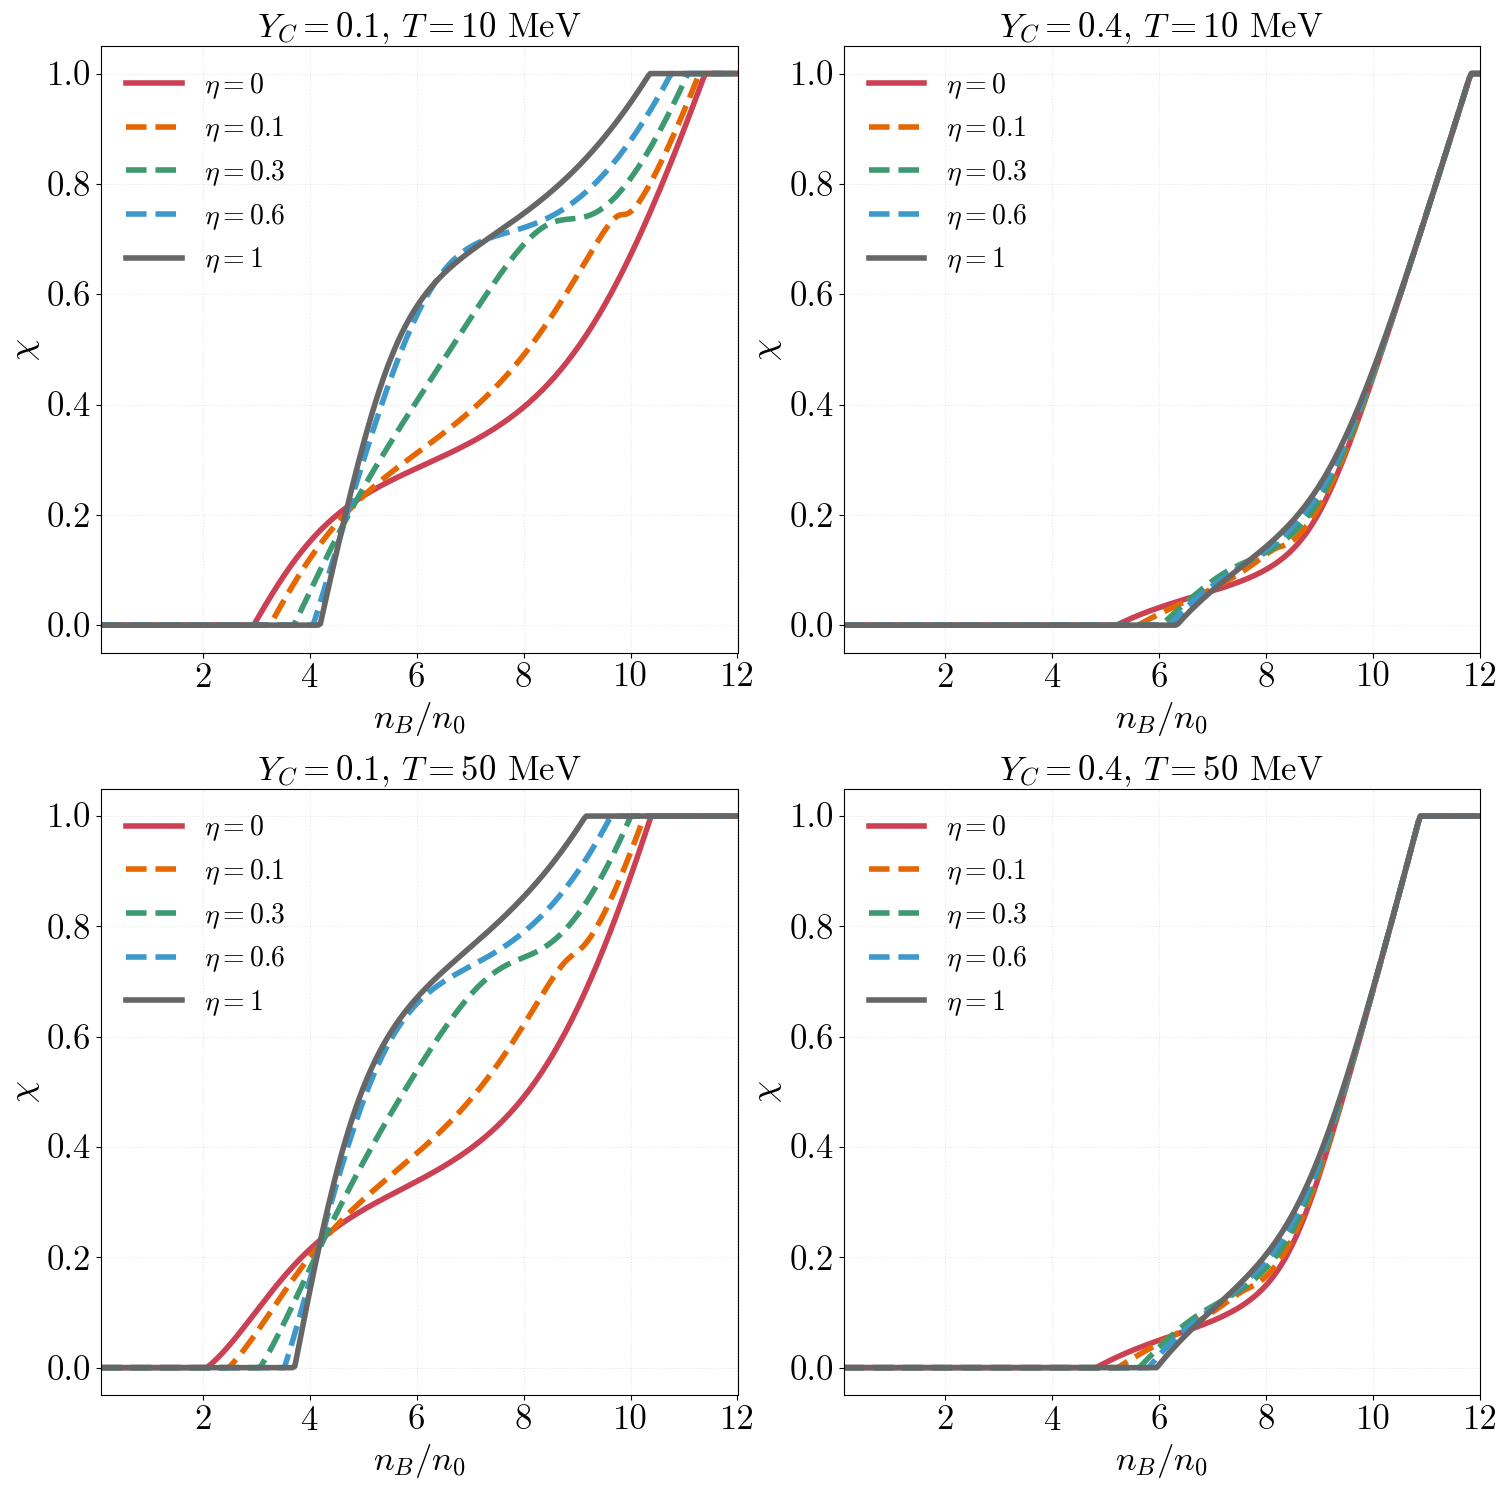

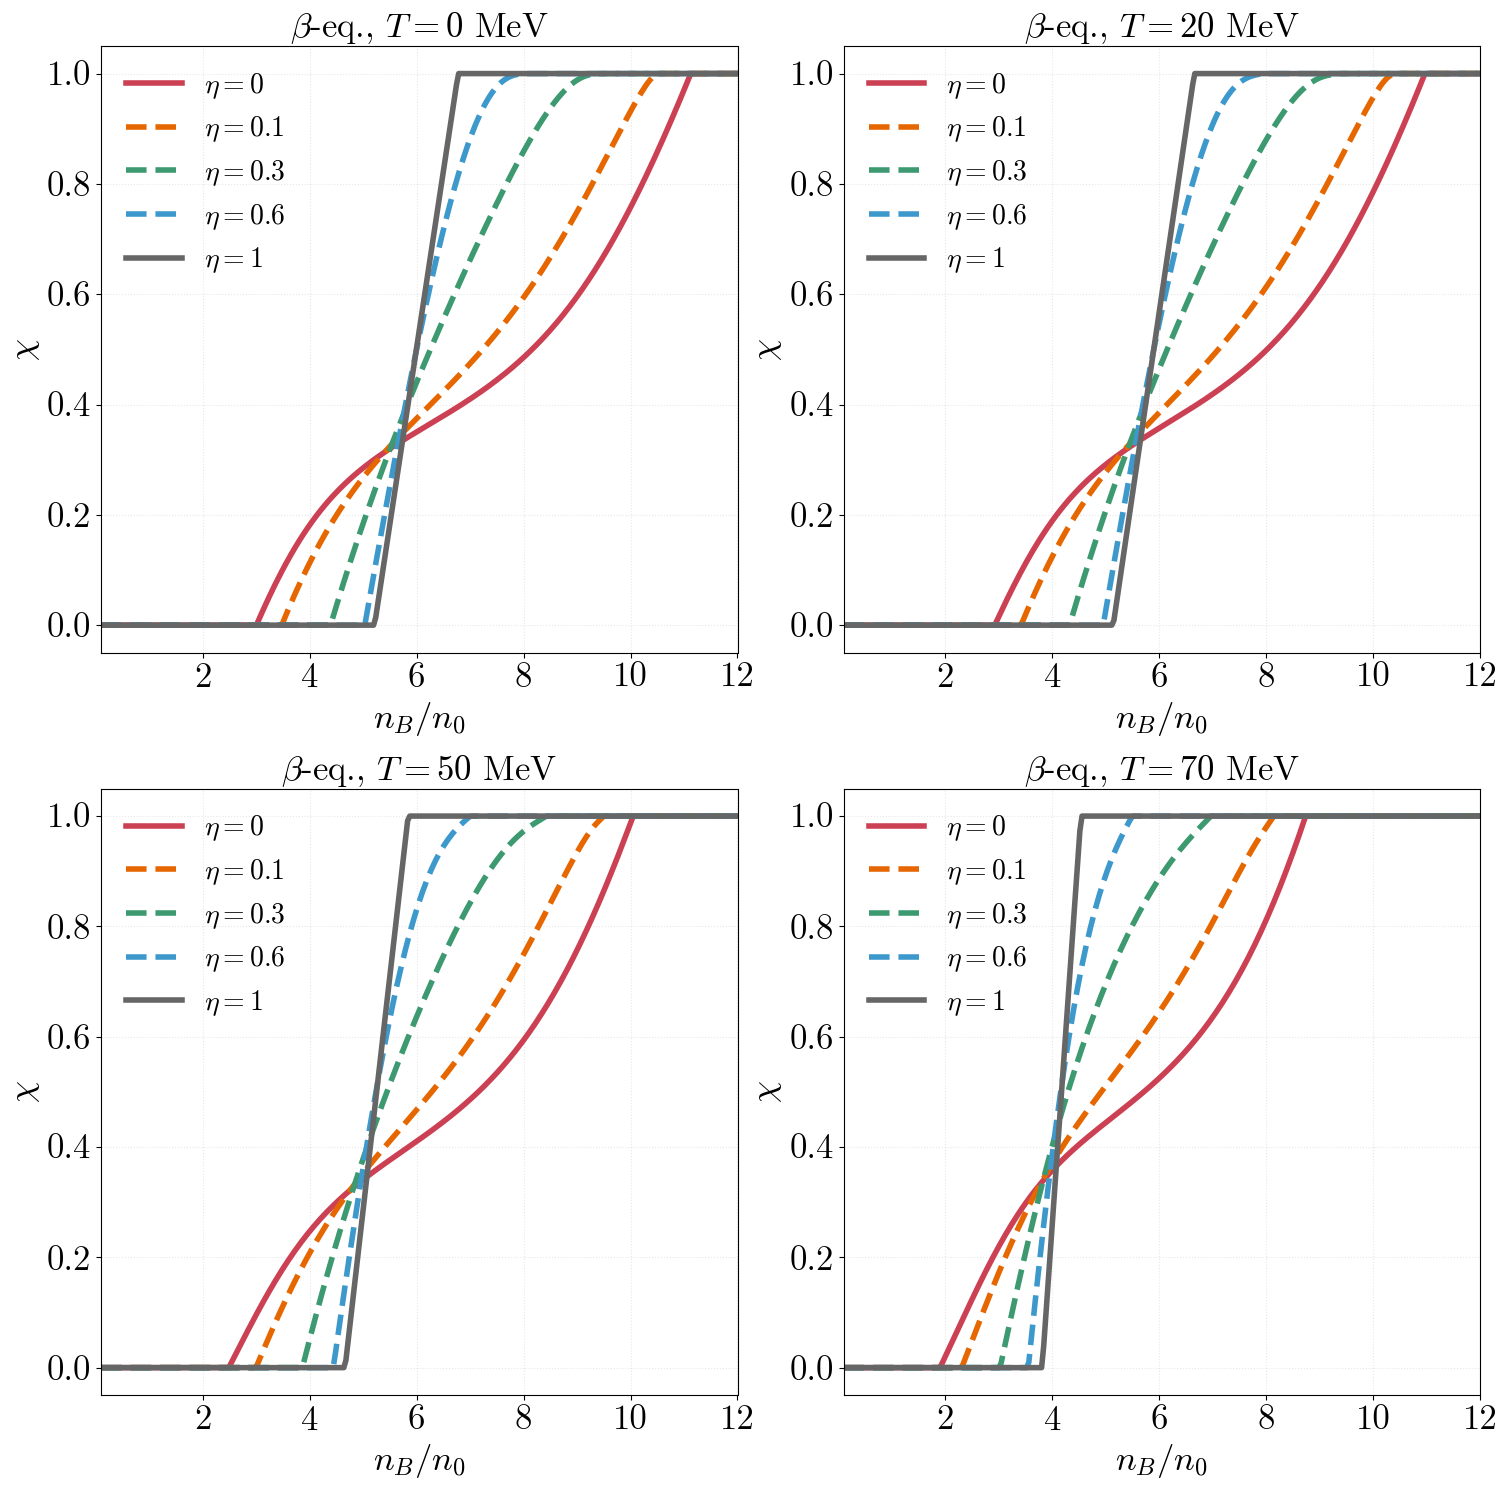

<Figure size 640x480 with 0 Axes>

In [11]:
# Define figure size
figsize = (15, 15)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
YC_T_set = [(0.1, 10), (0.4, 10), (0.1, 50), (0.4, 50)]

for (i, j), (Y_C, T) in zip(positions, YC_T_set):
    plot_fixedyc(axes[i, j], eos_fixedyc, 'chi', n_B_values, T, Y_C, eta_values, xlim=(0.1, 12), ylim=(-0.05, 1.05))

plt.tight_layout()
plt.show()






# Define figure size
figsize = (15, 15)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
T_plot = [0,20,50,70]

for (i, j), T in zip(positions, T_plot):
    plot_betaeq(axes[i, j], eos_betaeq, 'chi', n_B_values, T, eta_values, xlim=(0.1, 12), ylim=(-0.05, 1.05))

plt.tight_layout()
plt.show()

plt.tight_layout()

## Boundaries

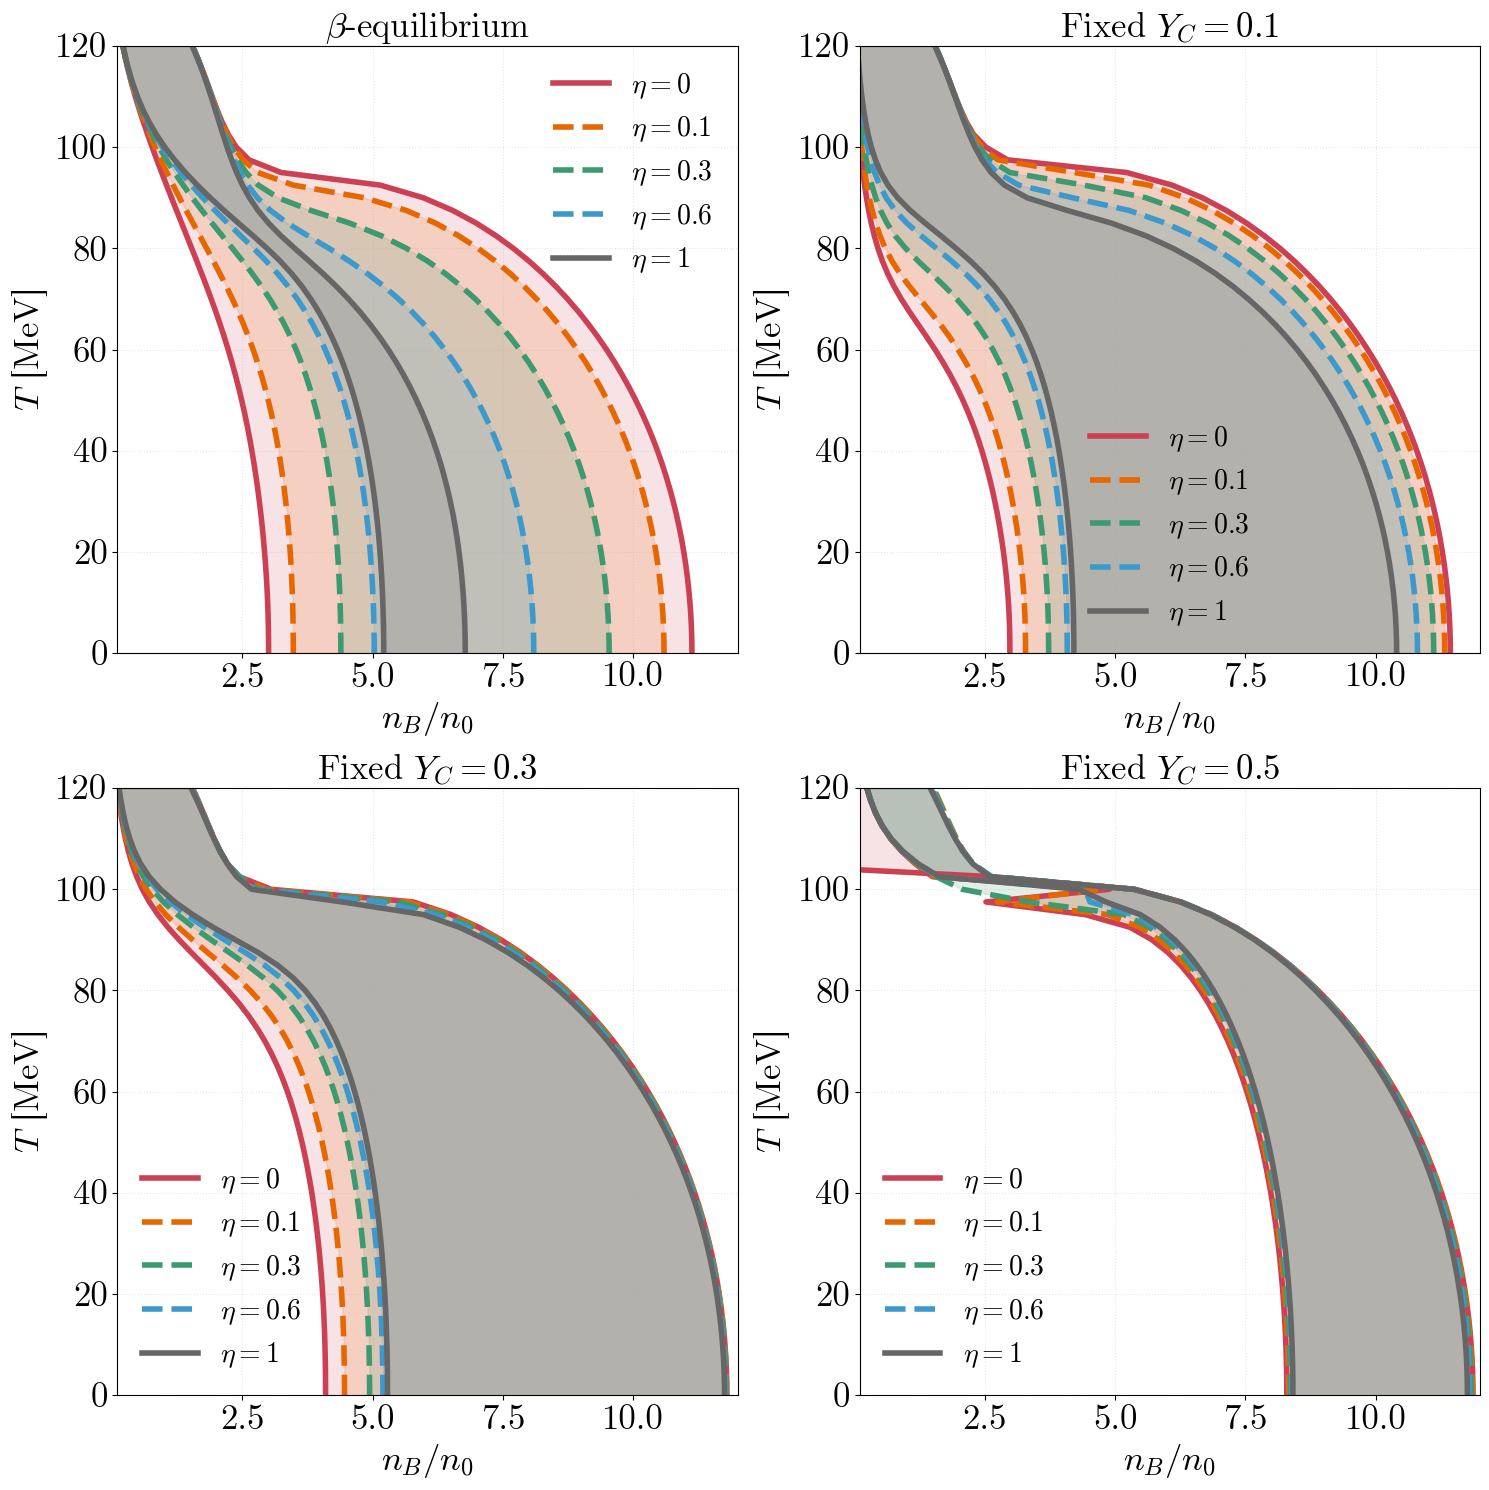

In [9]:
# ==============================================================================
# T(nB) PHASE DIAGRAM - Complete self-contained version
# ==============================================================================


# Create figure
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Beta equilibrium
plot_mixed_phase_boundaries(axes[0, 0], eos_betaeq, eta_values, Y_C=None,
                            normalize_nB=True, xlim=(.1, 12), ylim=(0, 120))
axes[0, 0].set_title(r'$\beta$-equilibrium')

# Fixed Y_C panels
for (i, j), YC in zip([(0, 1), (1, 0), (1, 1)], [0.1, 0.3, 0.5]):
    plot_mixed_phase_boundaries(axes[i, j], eos_fixedyc, eta_values, Y_C=YC,
                                normalize_nB=True, xlim=(.1, 12), ylim=(0, 120))
    axes[i, j].set_title(rf'Fixed $Y_C = {YC}$')

plt.tight_layout()
plt.show()

## Pressure

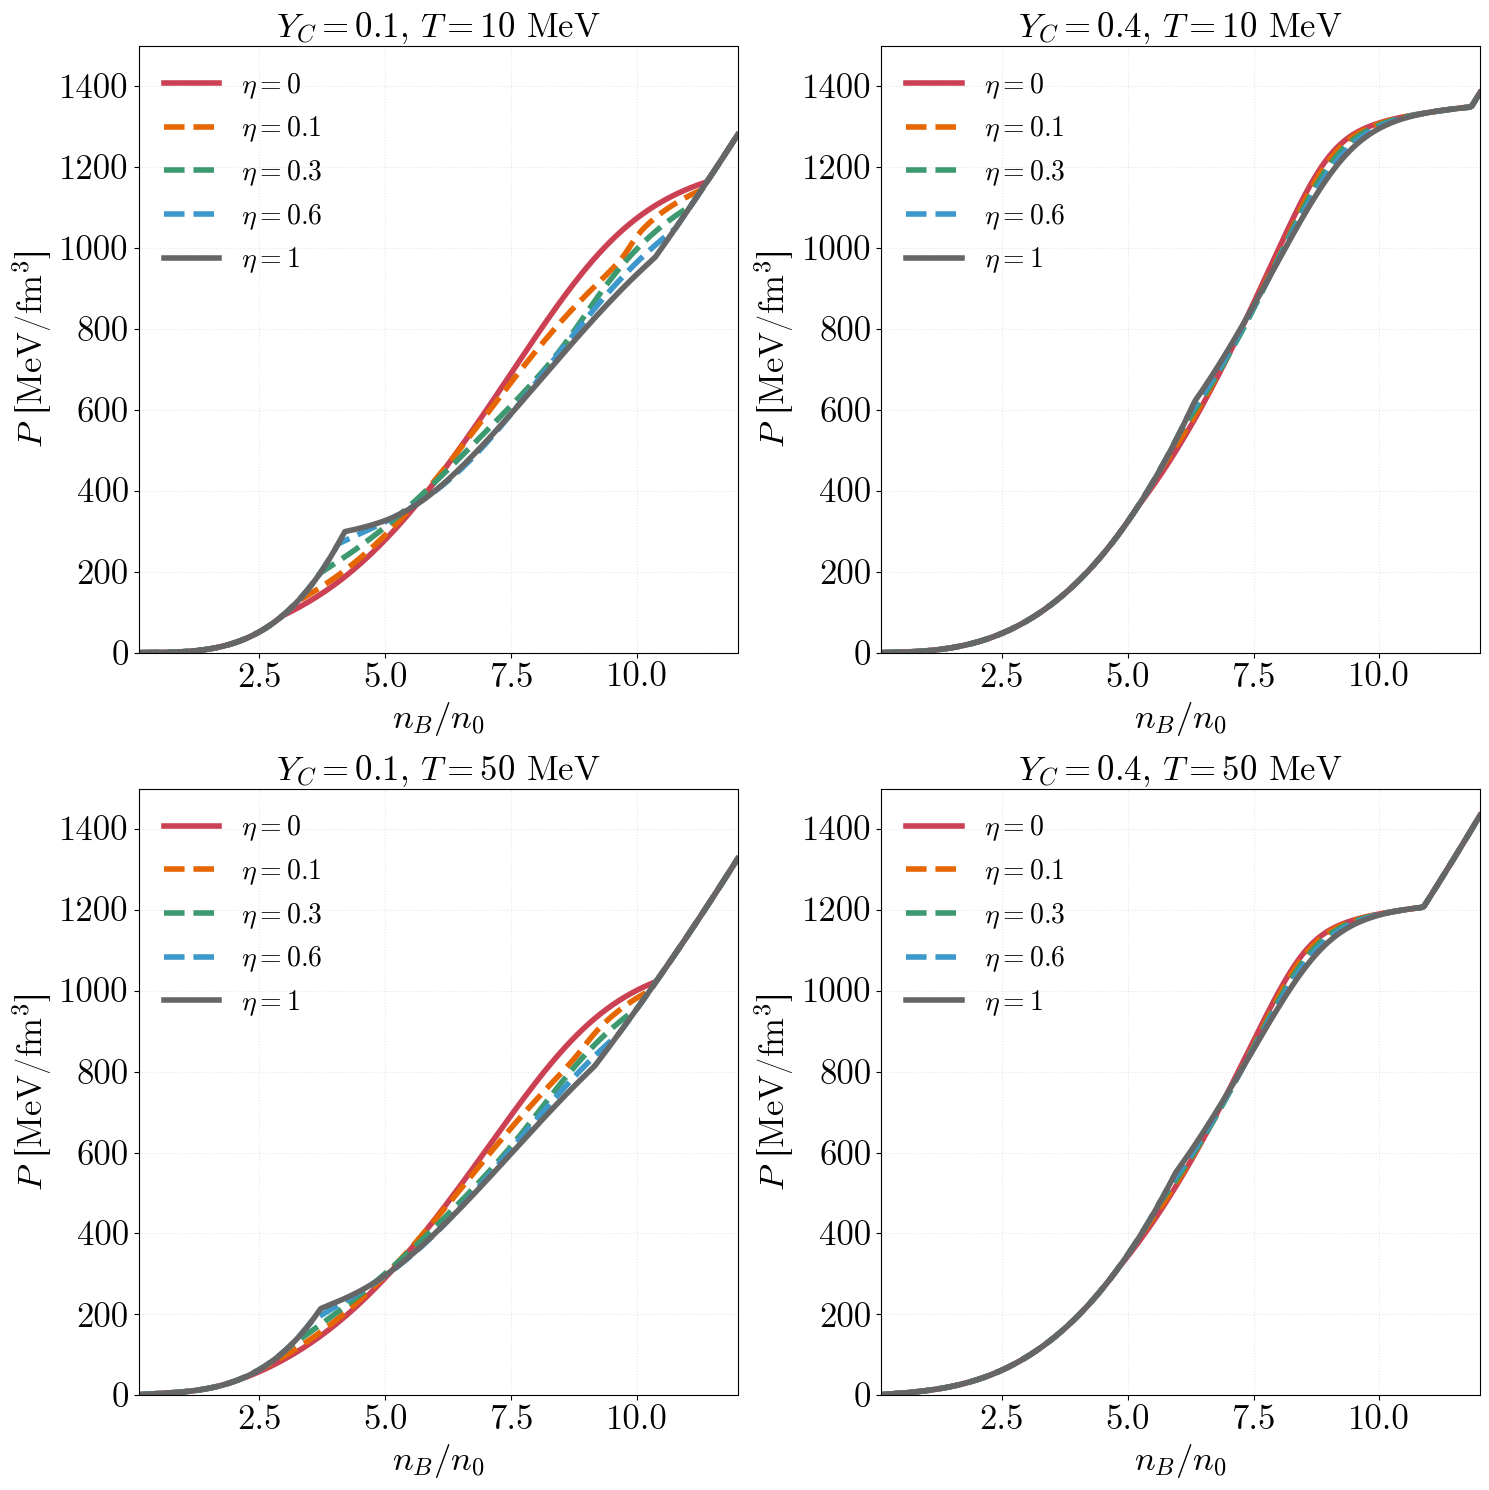

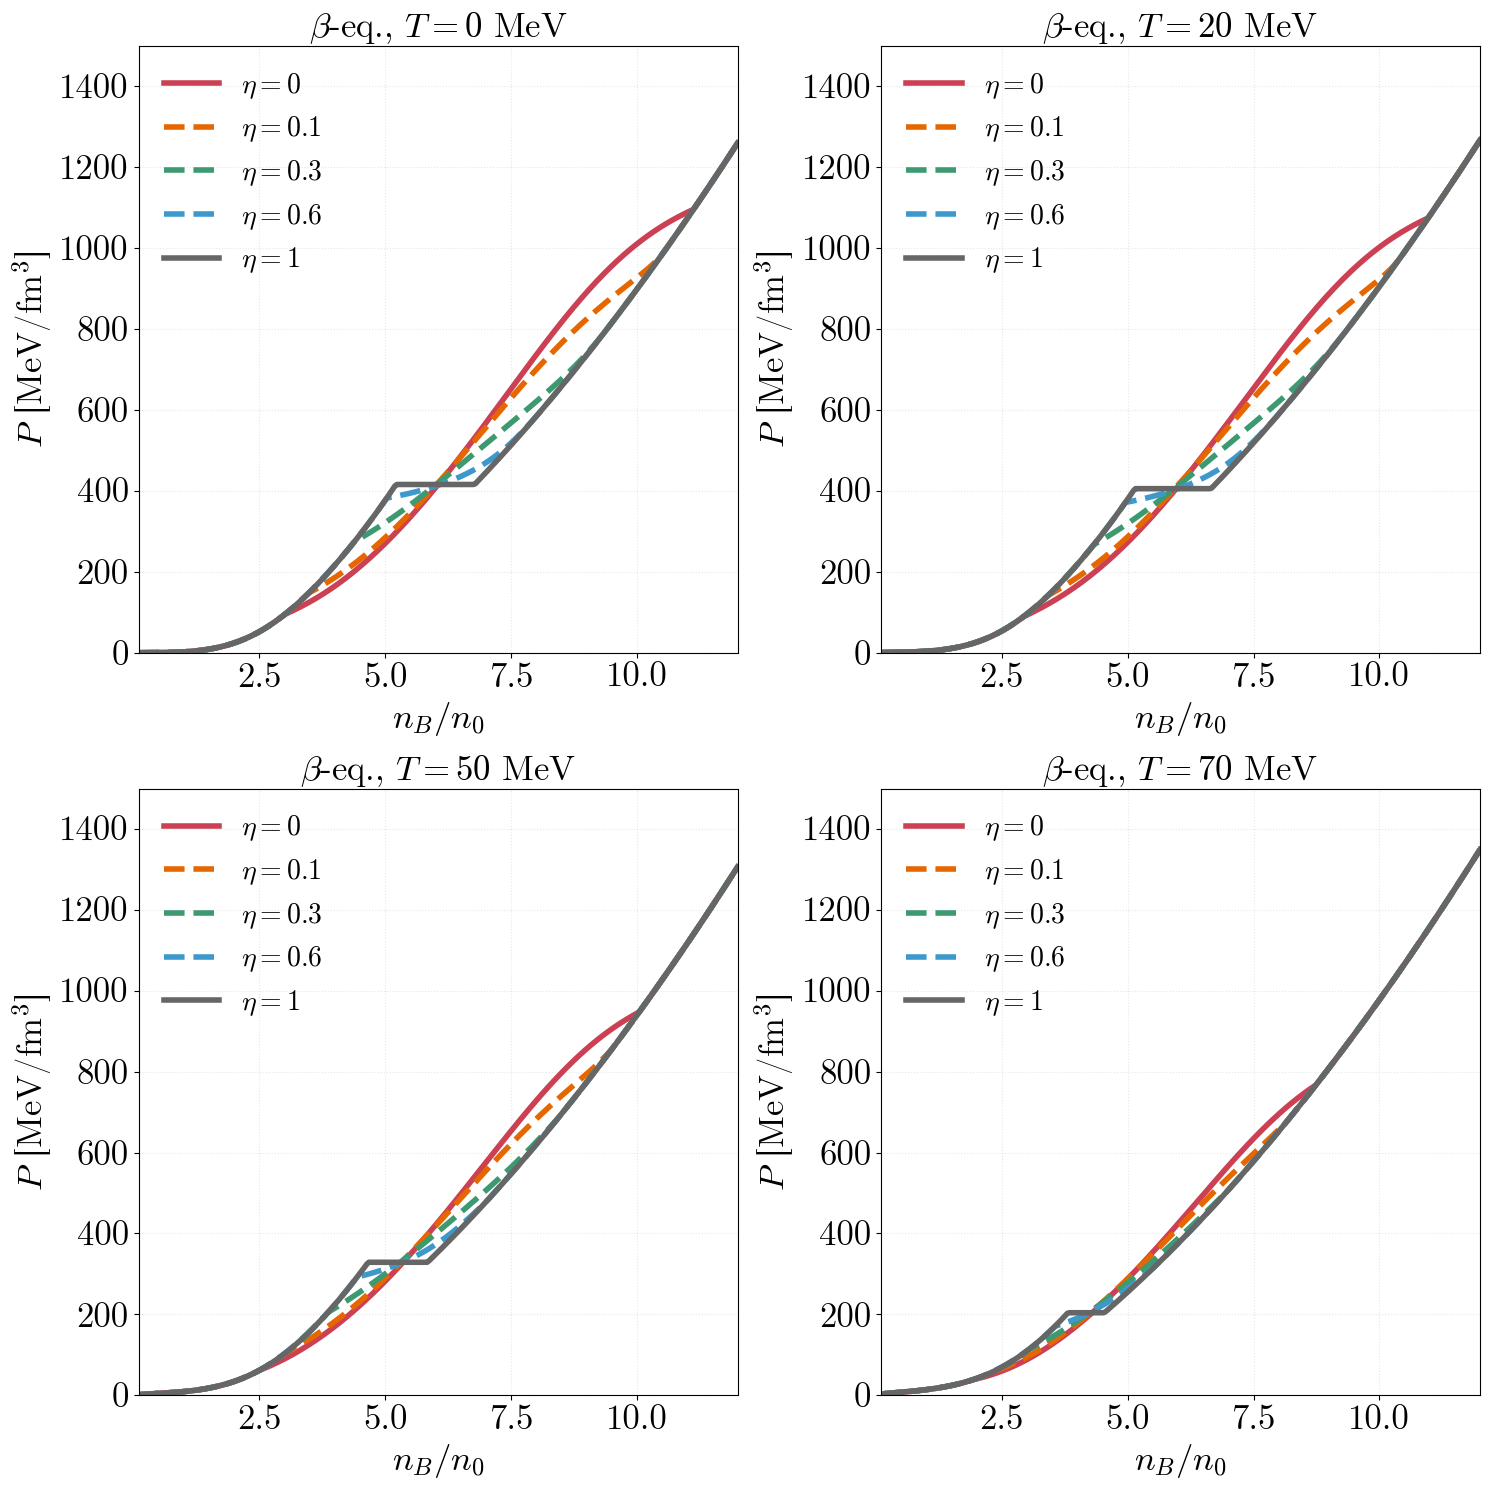

<Figure size 640x480 with 0 Axes>

In [13]:
# Define figure size
figsize = (15, 15)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
YC_T_set = [(0.1, 10), (0.4, 10), (0.1, 50), (0.4, 50)]

for (i, j), (Y_C, T) in zip(positions, YC_T_set):
    plot_fixedyc(axes[i, j], eos_fixedyc, 'P_total', n_B_values, T, Y_C, eta_values, xlim=(0.1, 12), ylim=(0, 1500))

plt.tight_layout()
plt.show()






# Define figure size
figsize = (15, 15)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
T_plot = [0,20,50,70]

for (i, j), T in zip(positions, T_plot):
    plot_betaeq(axes[i, j], eos_betaeq, 'P_total', n_B_values, T, eta_values, xlim=(0.1, 12), ylim=(0, 1500))

plt.tight_layout()
plt.show()

plt.tight_layout()

## Energy, Entropy, and Free Energy

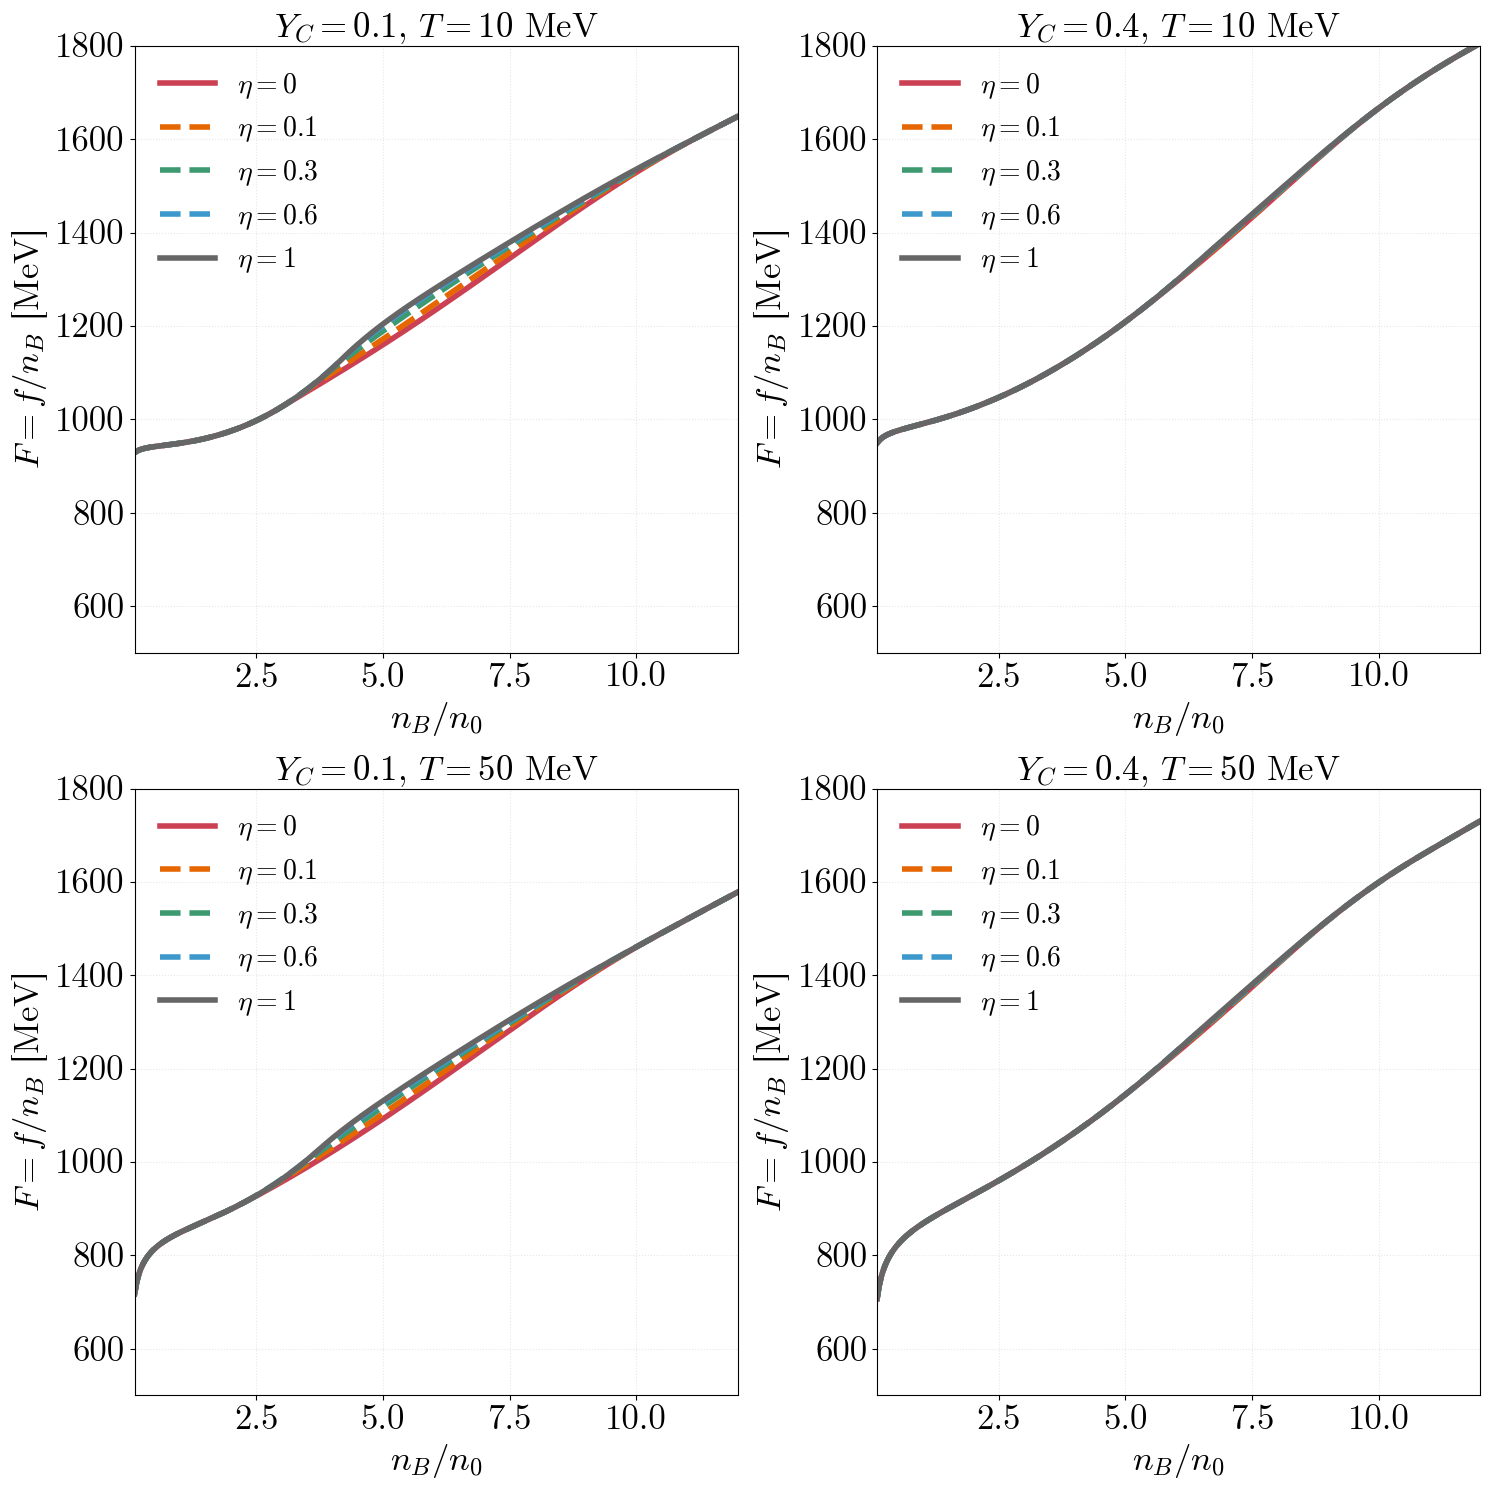

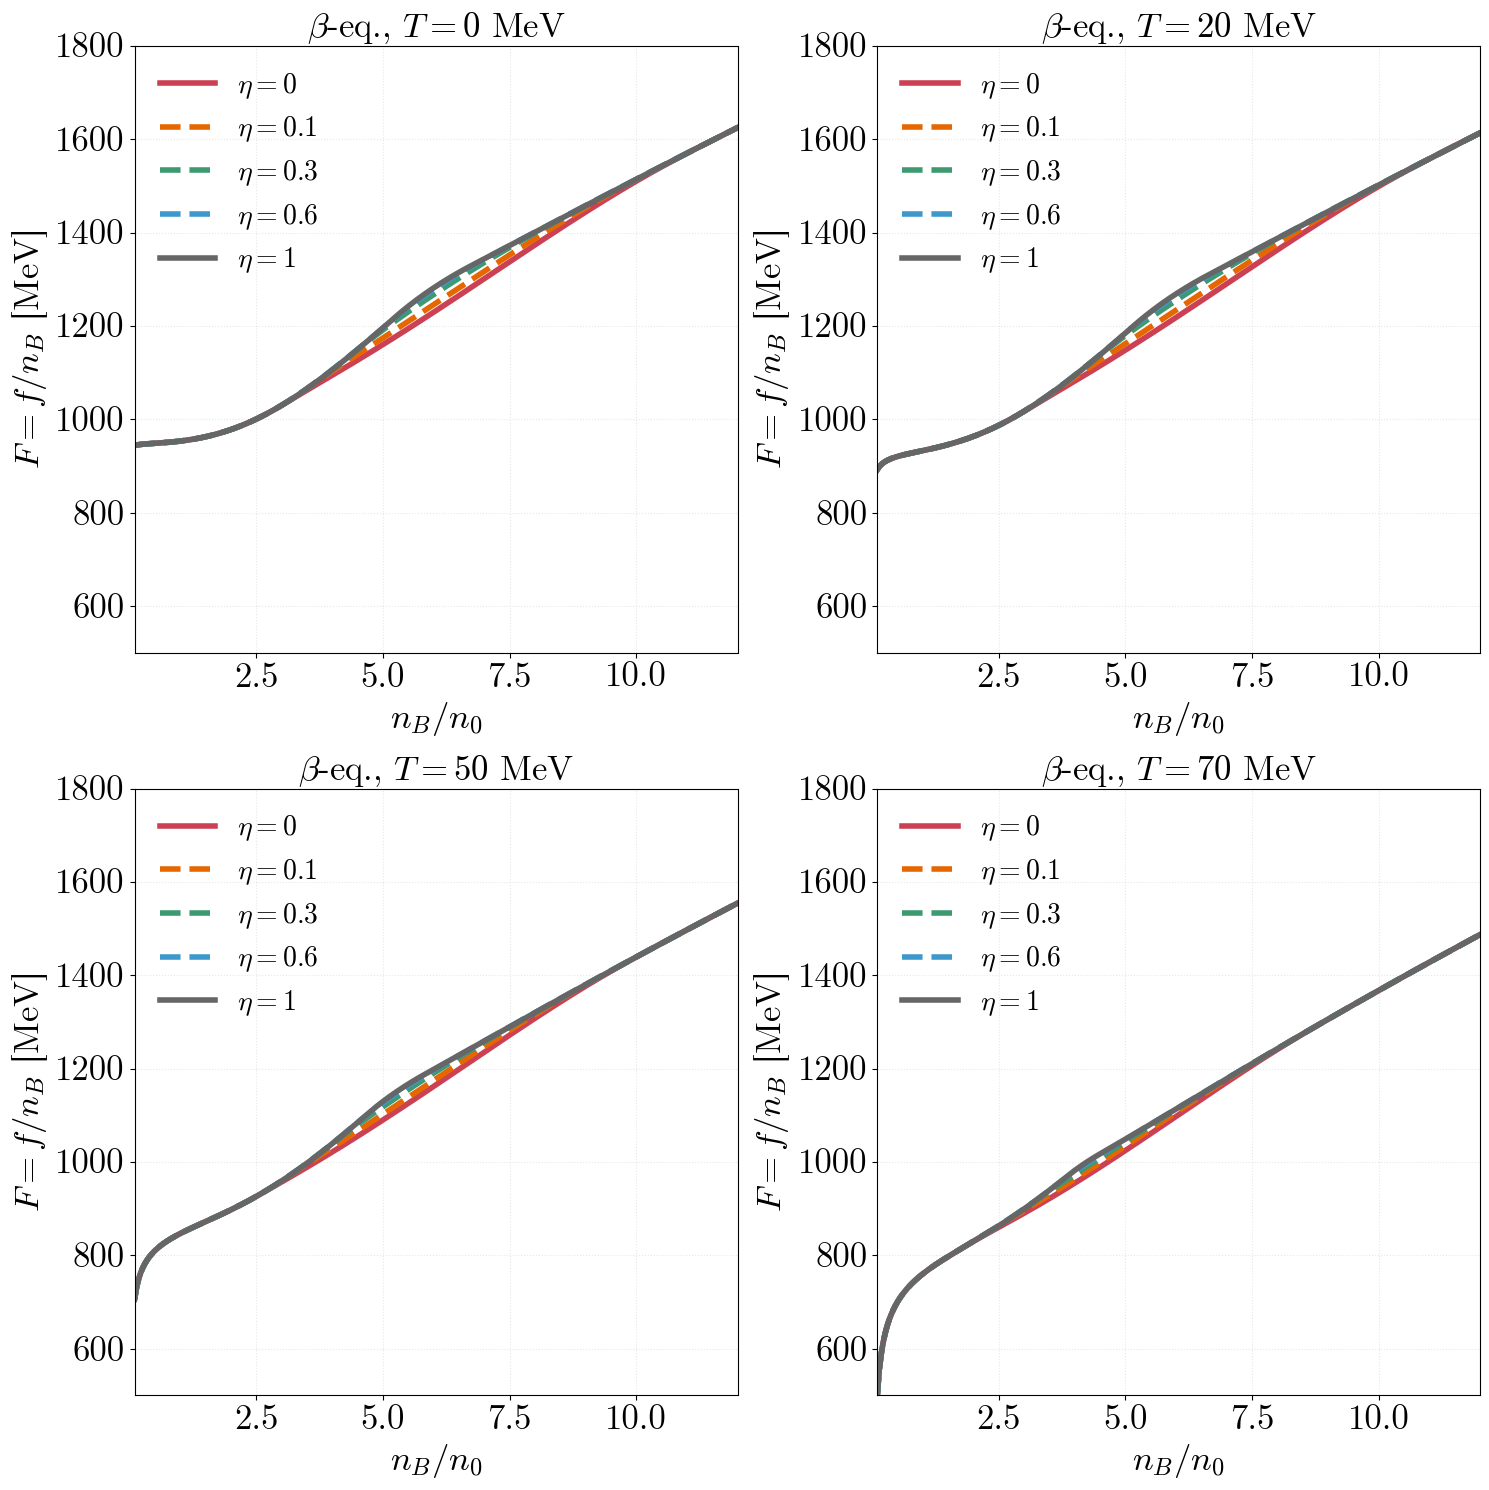

<Figure size 640x480 with 0 Axes>

In [14]:
# Define figure size
figsize = (15, 15)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
YC_T_set = [(0.1, 10), (0.4, 10), (0.1, 50), (0.4, 50)]

for (i, j), (Y_C, T) in zip(positions, YC_T_set):
    plot_fixedyc(axes[i, j], eos_fixedyc, 'F_specific', n_B_values, T, Y_C, eta_values, xlim=(0.1, 12), ylim=(500, 1800))

plt.tight_layout()
plt.show()






# Define figure size
figsize = (15, 15)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
T_plot = [0,20,50,70]

for (i, j), T in zip(positions, T_plot):
    plot_betaeq(axes[i, j], eos_betaeq, 'F_specific', n_B_values, T, eta_values, xlim=(0.1, 12), ylim=(500, 1800))

plt.tight_layout()
plt.show()

plt.tight_layout()

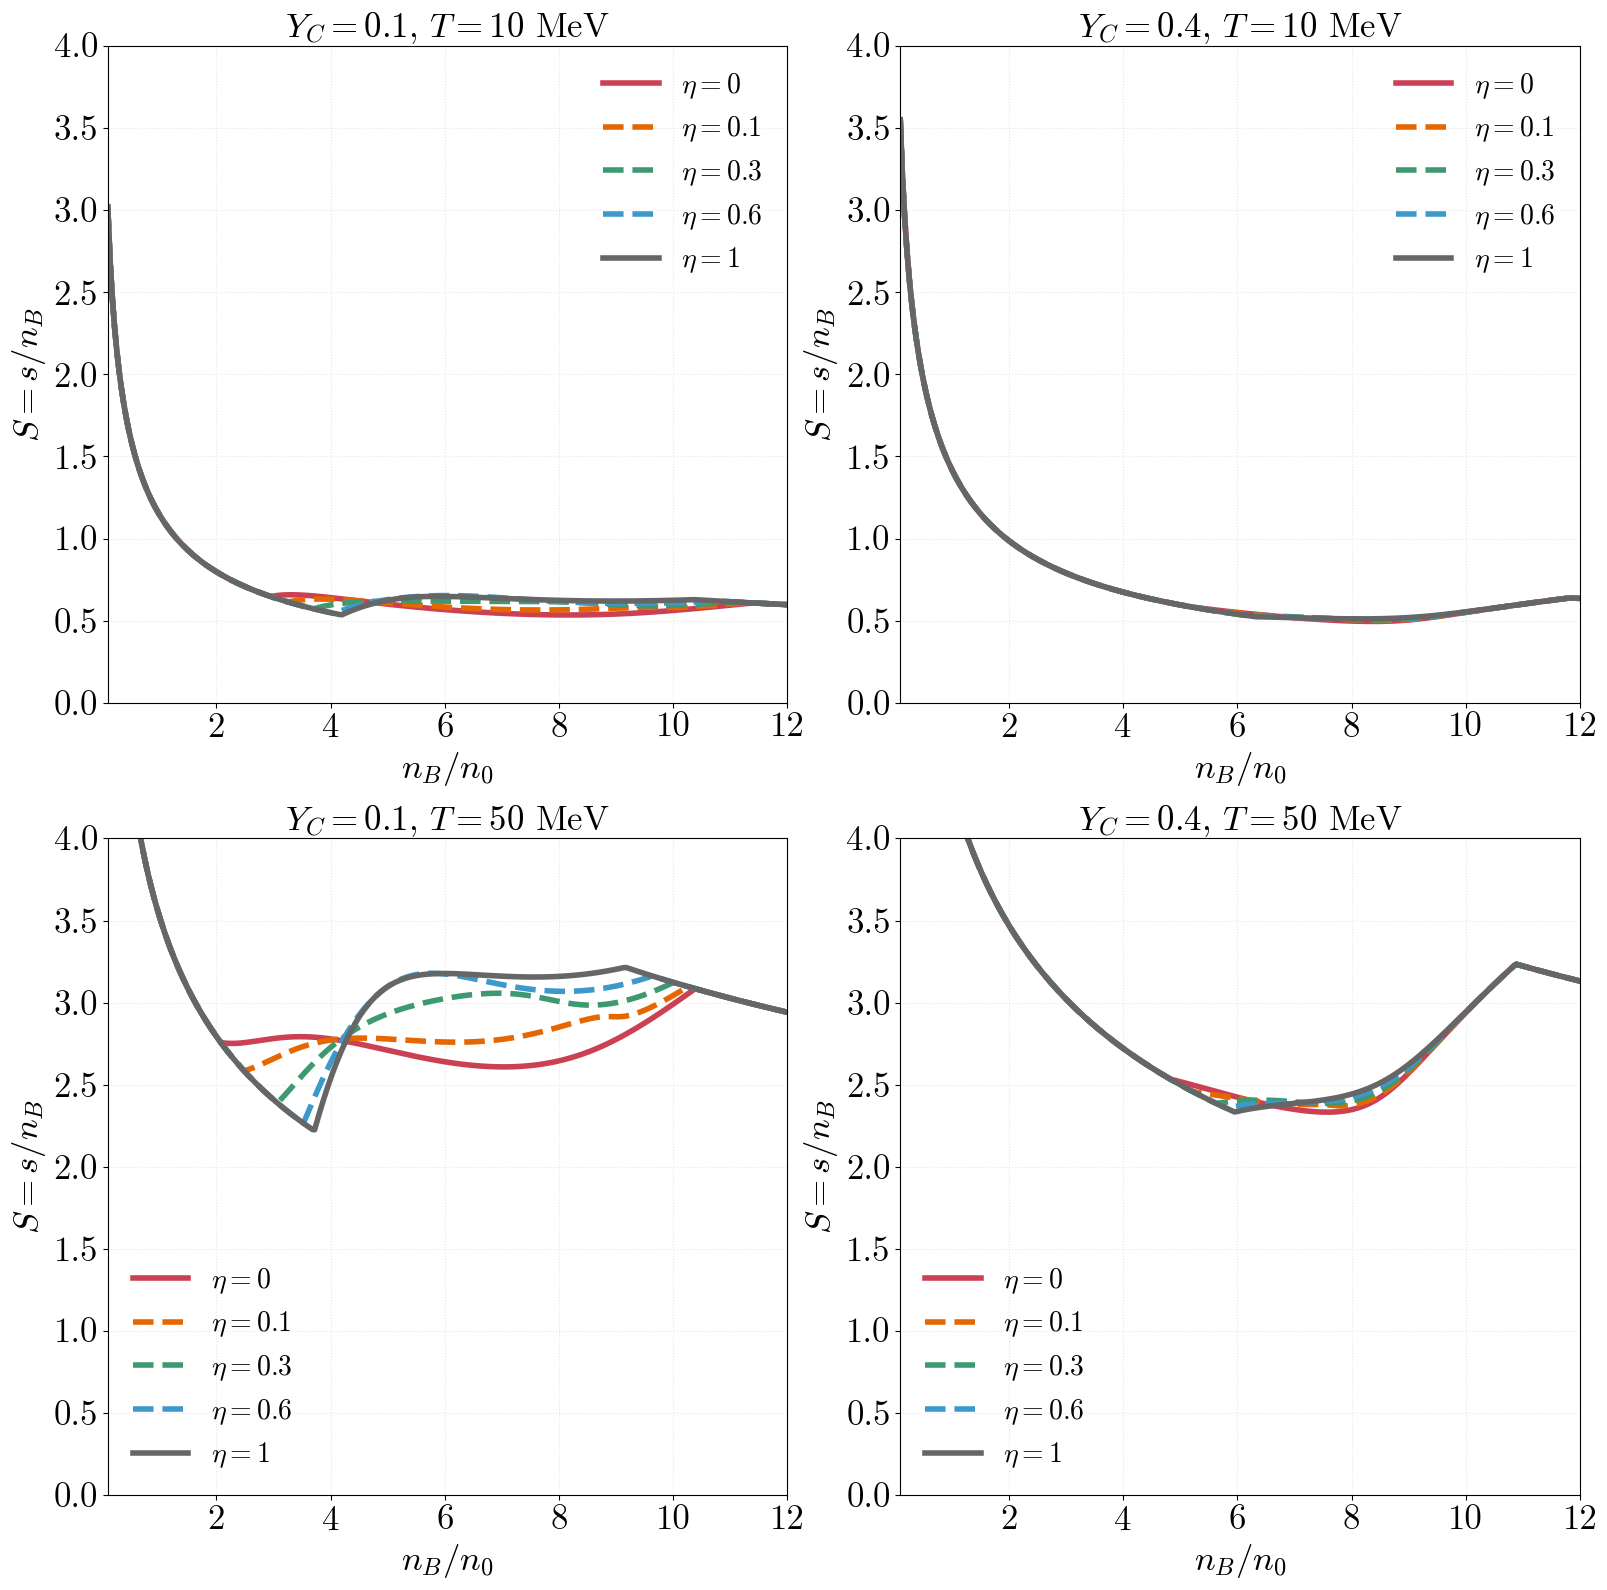

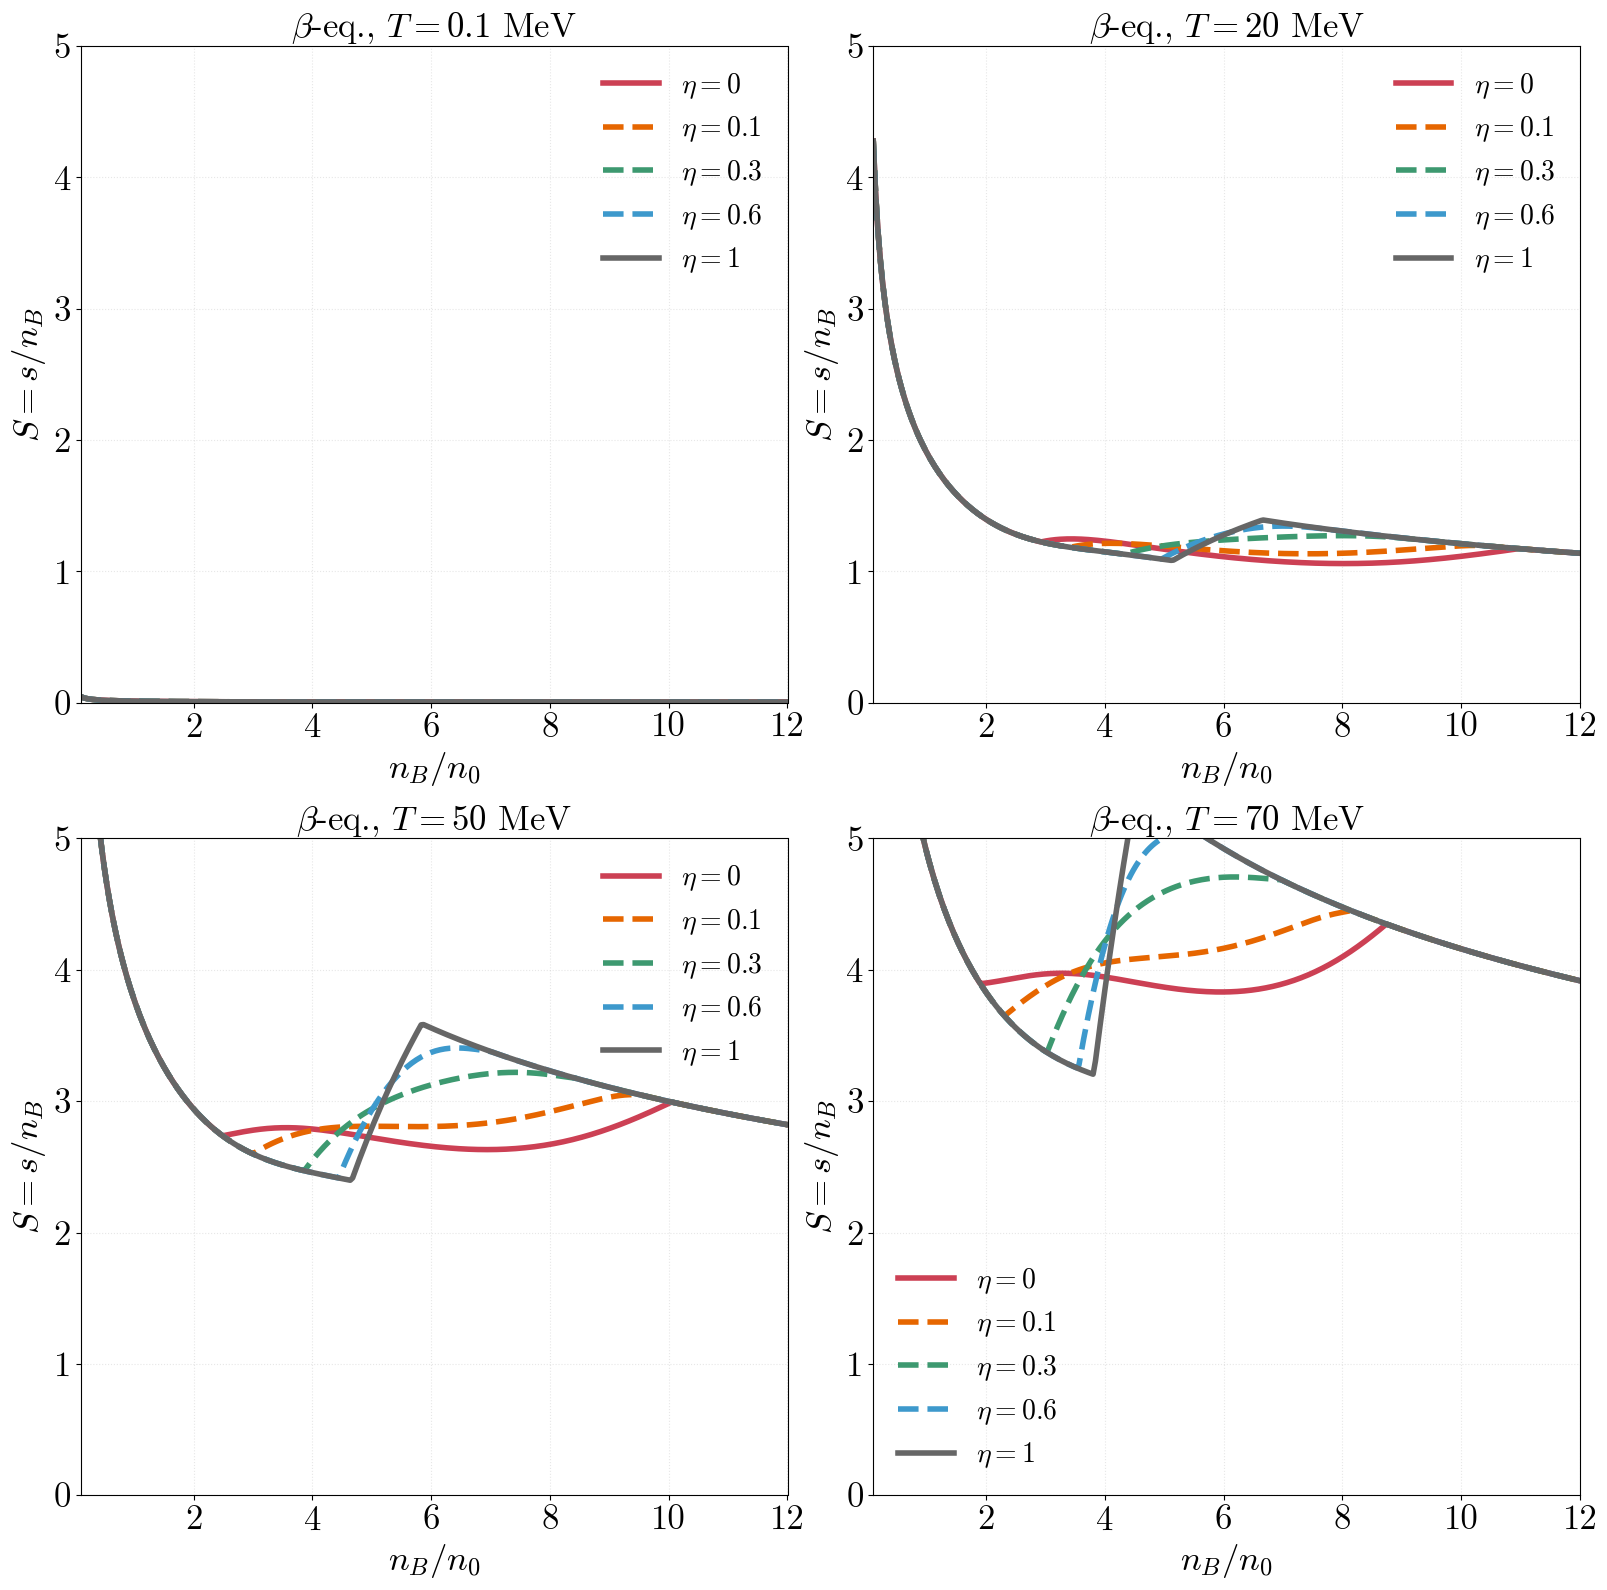

<Figure size 640x480 with 0 Axes>

In [10]:
# Define figure size
figsize = (16, 16)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
YC_T_set = [(0.1, 10), (0.4, 10), (0.1, 50), (0.4, 50)]

for (i, j), (Y_C, T) in zip(positions, YC_T_set):
    plot_fixedyc(axes[i, j], eos_fixedyc, 'S_specific', n_B_values, T, Y_C, eta_values, xlim=(0.1, 12), ylim=(0, 4))

plt.tight_layout()
plt.show()






# Define figure size
figsize = (16, 16)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
T_plot = [0.1,20,50,70]

for (i, j), T in zip(positions, T_plot):
    plot_betaeq(axes[i, j], eos_betaeq, 'S_specific', n_B_values, T, eta_values, xlim=(0.1, 12), ylim=(0, 5))

plt.tight_layout()
plt.show()

plt.tight_layout()

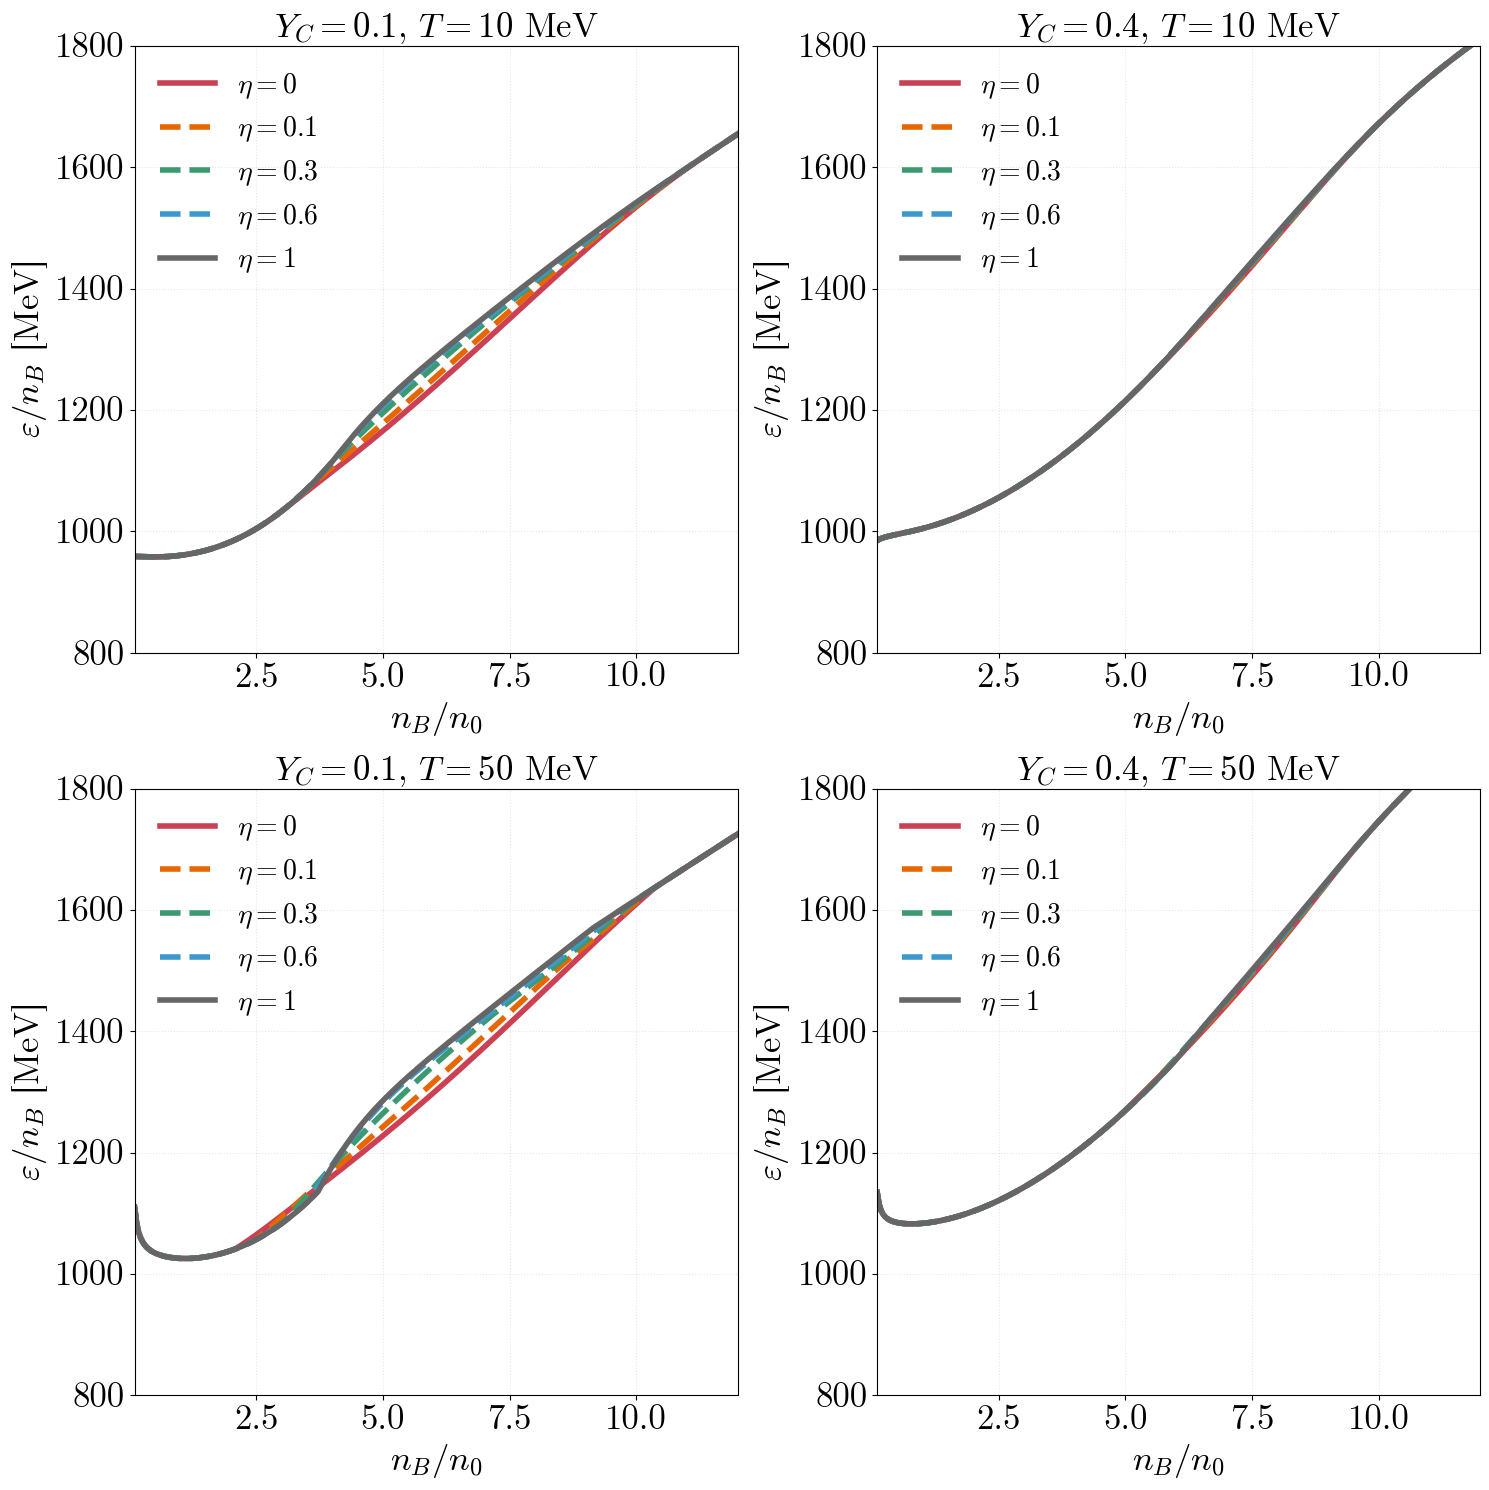

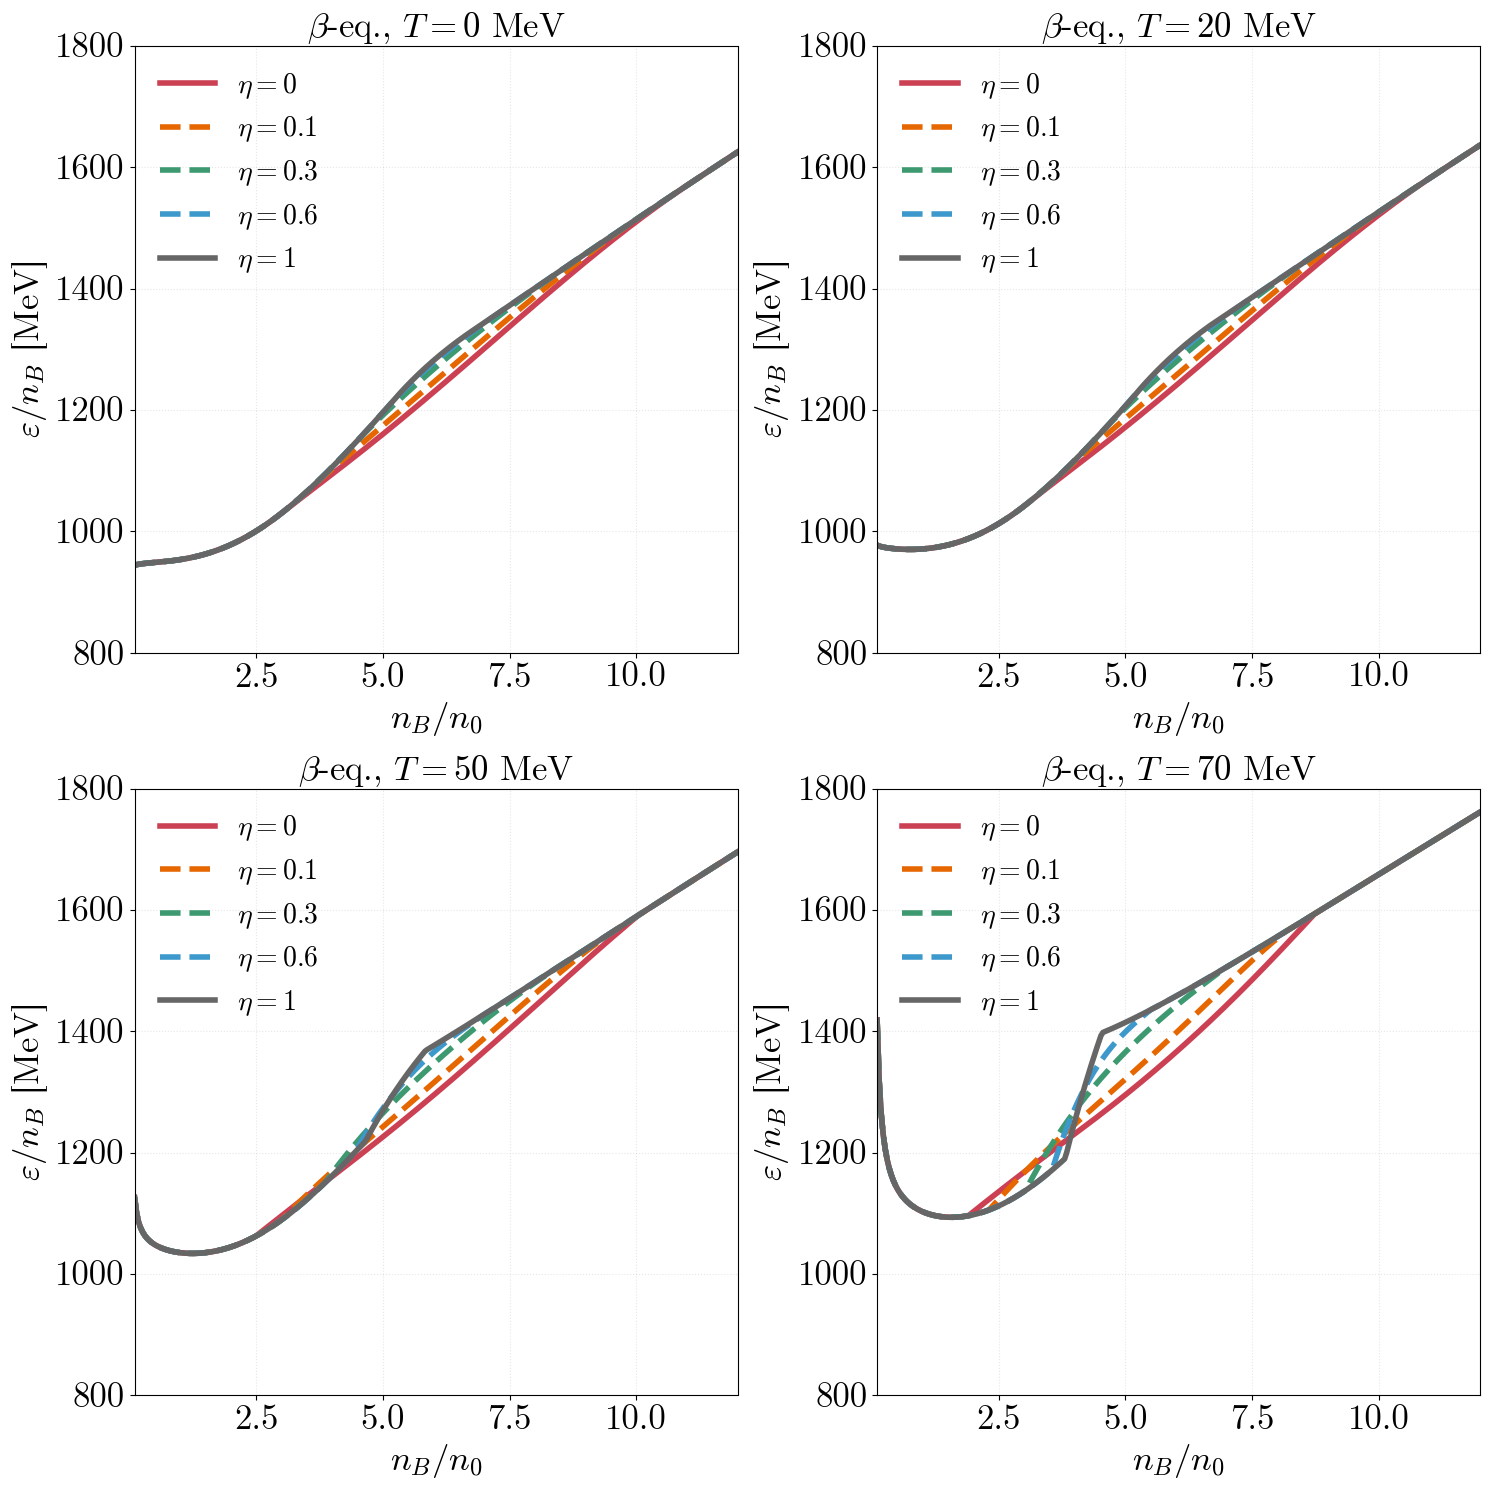

<Figure size 640x480 with 0 Axes>

In [16]:
# Define figure size
figsize = (15, 15)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
YC_T_set = [(0.1, 10), (0.4, 10), (0.1, 50), (0.4, 50)]

for (i, j), (Y_C, T) in zip(positions, YC_T_set):
    plot_fixedyc(axes[i, j], eos_fixedyc, 'e_per_nB', n_B_values, T, Y_C, eta_values, xlim=(0.1, 12), ylim=(800, 1800))

plt.tight_layout()
plt.show()






# Define figure size
figsize = (15, 15)

fig, axes = plt.subplots(2, 2, figsize=figsize)

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
T_plot = [0,20,50,70]

for (i, j), T in zip(positions, T_plot):
    plot_betaeq(axes[i, j], eos_betaeq, 'e_per_nB', n_B_values, T, eta_values, xlim=(0.1, 12), ylim=(800, 1800))

plt.tight_layout()
plt.show()

plt.tight_layout()

## Composition

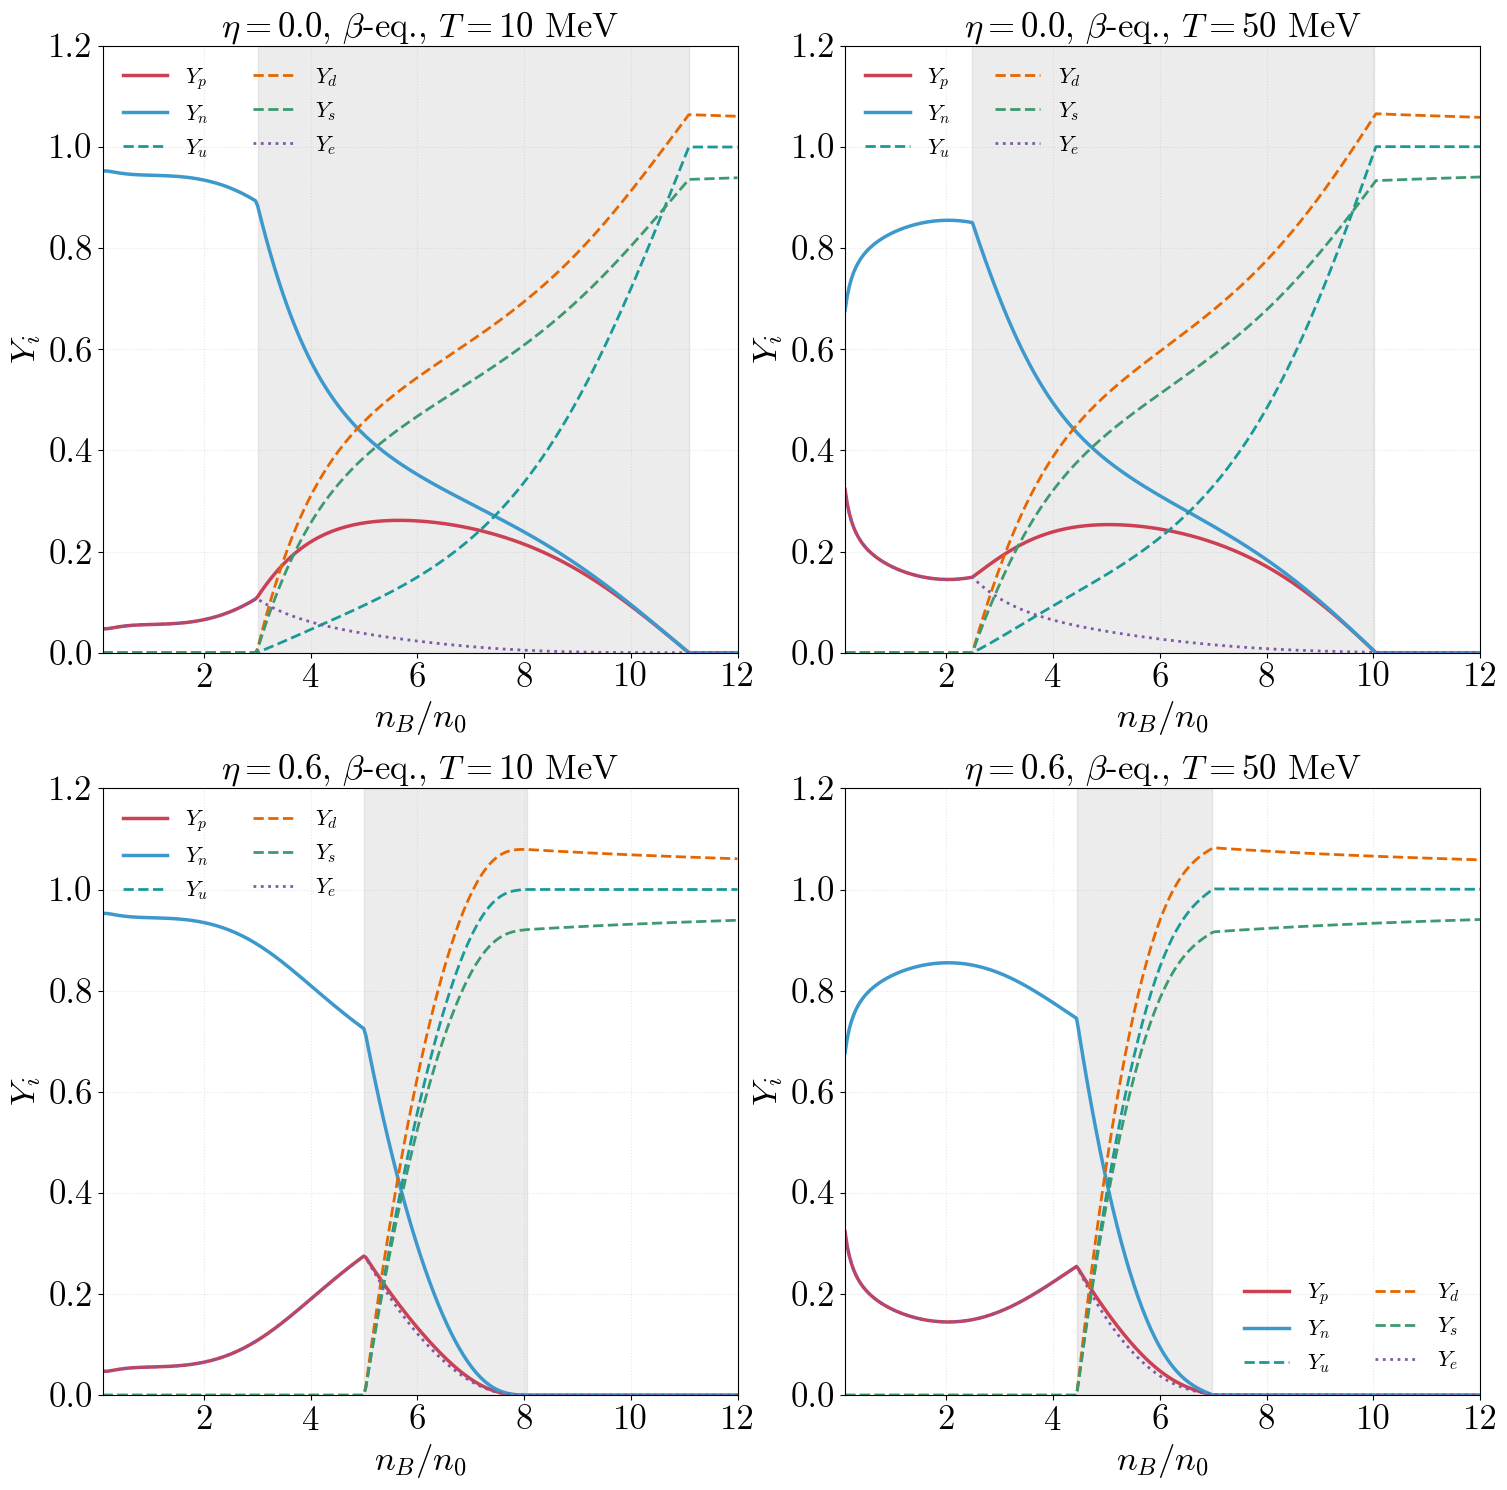

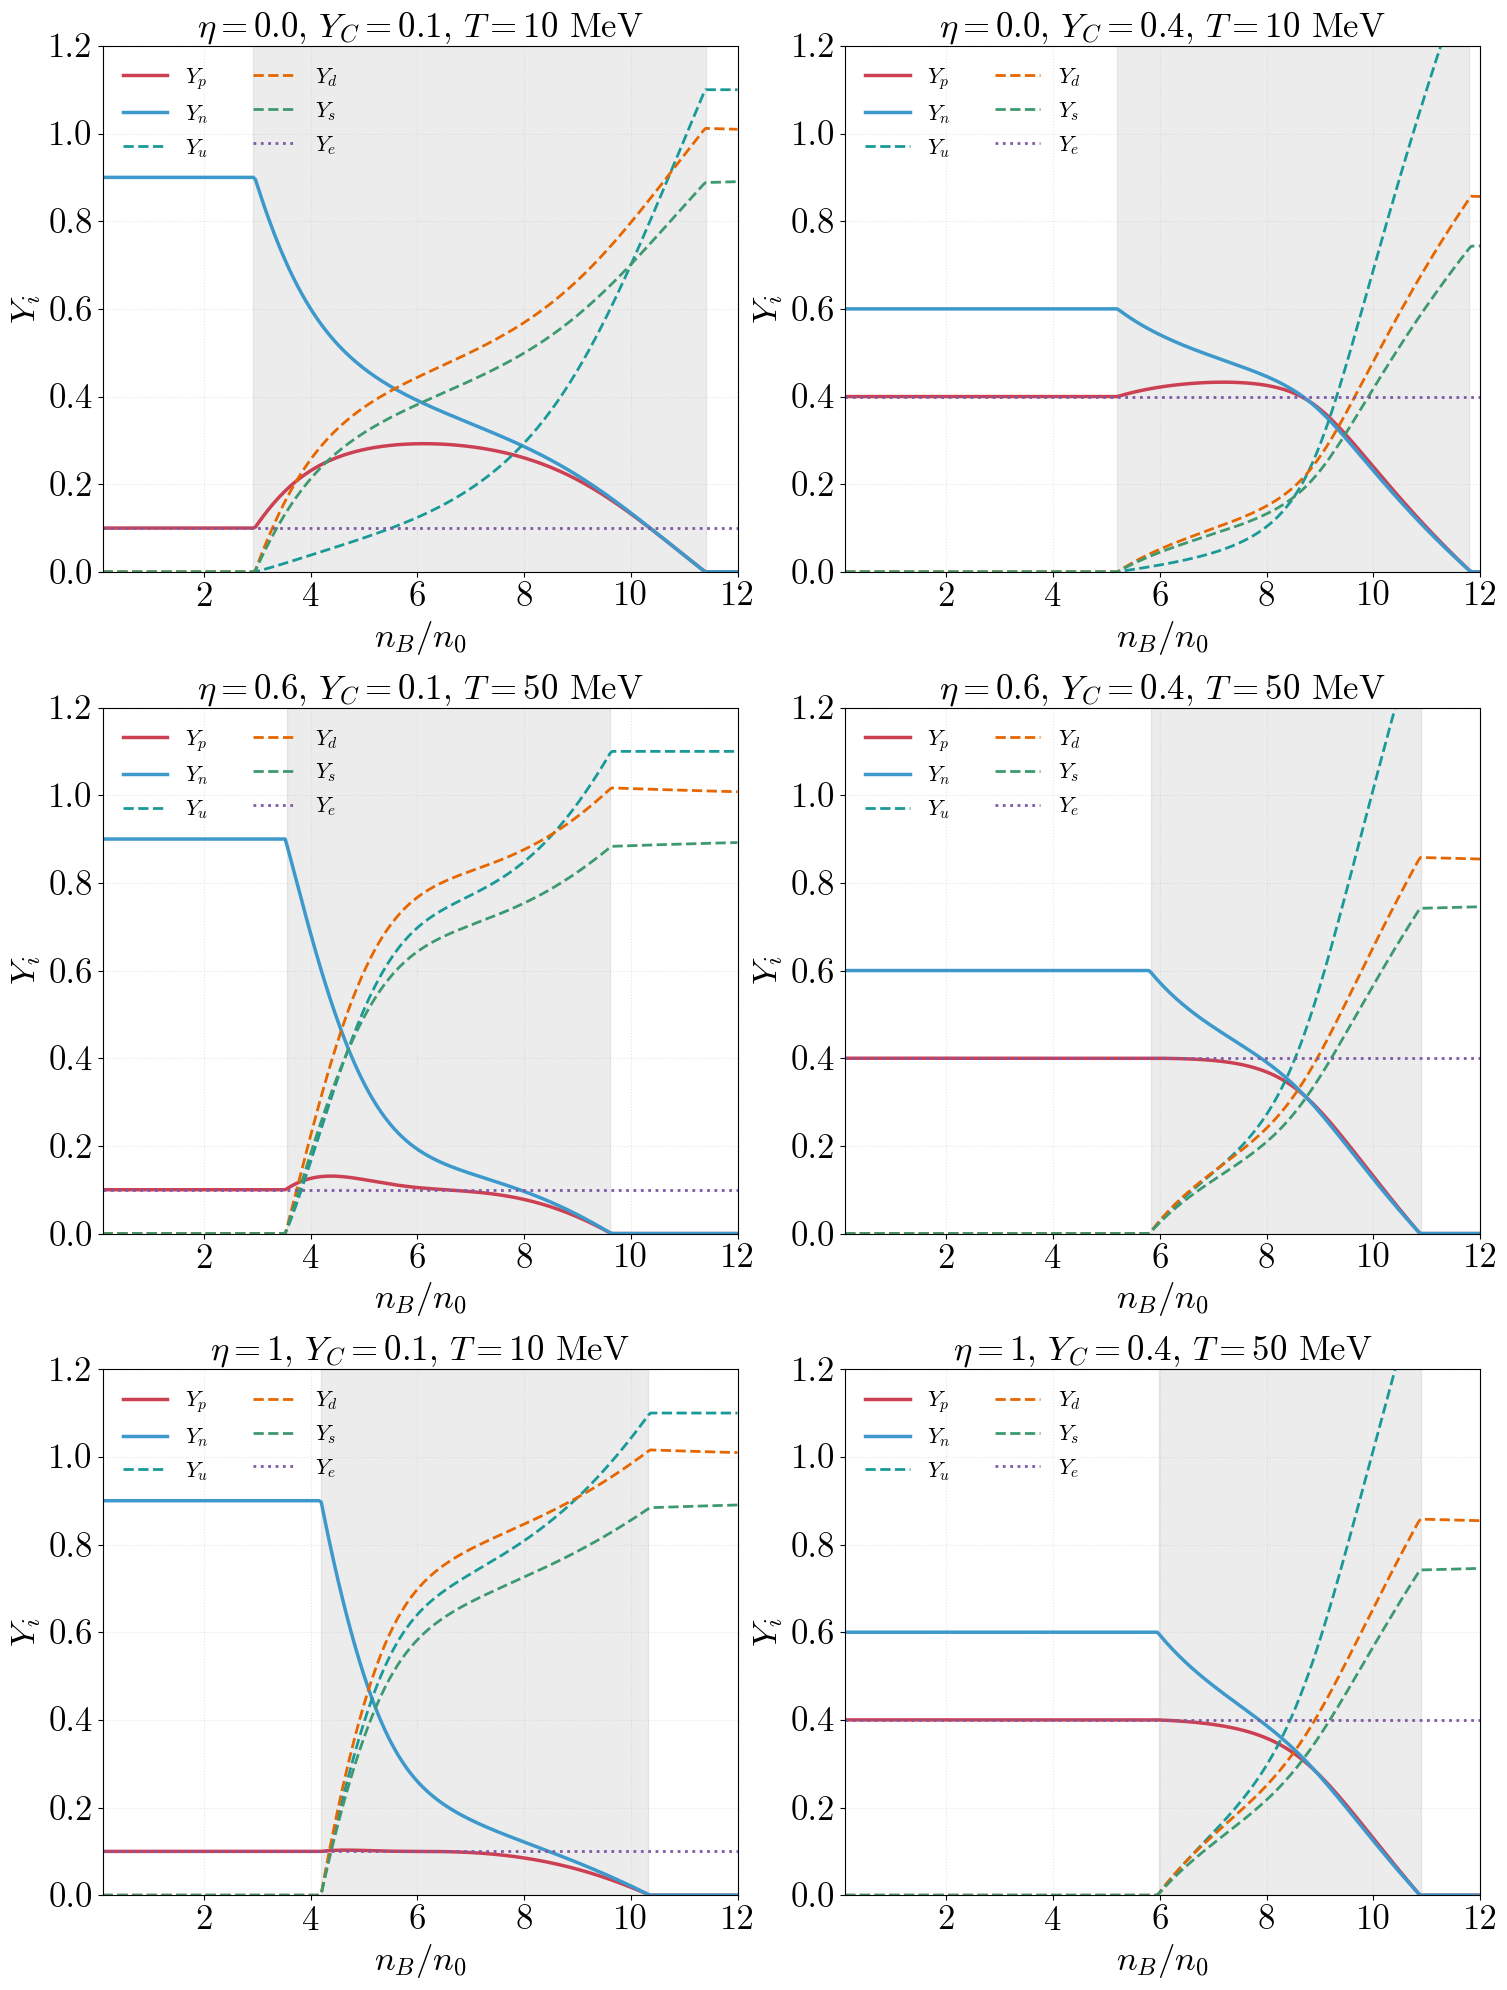

In [17]:
## Composition Y_i(nB) - Beta equilibrium

# Plot basic composition (Y_p, Y_n, Y_u, Y_d, Y_s, Y_e)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
eta_T_set = [(0.0, 10), (0.0, 50), (0.6, 10), (0.6, 50)]

for (i, j), (eta, T) in zip(positions, eta_T_set):
    plot_composition(axes[i, j], eos_betaeq, n_B_values, T, eta, 
                     species='basic', xlim=(0.1, 12), ylim=(0, 1.2))

plt.tight_layout()
plt.show()

## Composition Y_i(nB) - Fixed YC

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
positions = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
eta_YC_T_set = [(0.0, 0.1, 10), (0.0, 0.4, 10), (0.6, 0.1, 50), (0.6, 0.4, 50), (1, 0.1, 10), (1, 0.4, 50)]

for (i, j), (eta, YC, T) in zip(positions, eta_YC_T_set):
    plot_composition(axes[i, j], eos_fixedyc, n_B_values, T, eta, 
                     species='basic', Y_C=YC, xlim=(0.1, 12), ylim=(0, 1.2))

plt.tight_layout()
plt.show()

# TOV Equations

In [18]:
### Compute the T=0 mixed phase hybrid EOS ZL+vMIT

# Directory for TOV outputs
from pathlib import Path
from eos import REPO_ROOT
OUTPUT_DIR_TOV = REPO_ROOT / "output" / "zlvmit_eos" / "tov"
OUTPUT_DIR_TOV.mkdir(parents=True, exist_ok=True)


## Pure phases

# ZL pure phase table settings
zl_settings = ZLTableSettings(
    params=zl_params,
    n_B_values=n_B_values,
    T_values=[0.],
    equilibrium='beta_eq',
    include_photons=True,
    print_results=VERBOSE,
    print_first_n=1
)

# vMIT pure phase table settings  
vmit_settings = VMITTableSettings(
    params=vmit_params,
    n_B_values=n_B_values,
    T_values=[0.],
    equilibrium='beta_eq',
    include_photons=True,
    print_results=VERBOSE,
    print_first_n=1
)

# Compute ZL table
zl_table_by_T = compute_zl_table(zl_settings)

# Compute vMIT table
vmit_table_by_T = compute_vmit_table(vmit_settings)


# Convert to lookup format
zl_table = {}
for key, results in zl_table_by_T.items():
    T = key[0]
    for i, r in enumerate(results):
        if r.converged:
            zl_table[(n_B_values[i], T)] = r

vmit_table = {}
for key, results in vmit_table_by_T.items():
    T = key[0]
    for i, r in enumerate(results):
        if r.converged:
            vmit_table[(n_B_values[i], T)] = r



# Compute boundaries
boundaries = {}
for eta in eta_values:
    print(f"Computing boundaries for η = {eta}")
    boundaries[eta] = get_or_compute_boundaries(
        eta=eta,
        T_values=[0.],
        zl_params=zl_params,
        vmit_params=vmit_params,
        output_dir=OUTPUT_DIR_TOV,  
        force_recompute=True,
        verbose=VERBOSE,
        H_table_lookup=zl_table,
        Q_table_lookup=vmit_table,
        return_dict=True
    )

# Generate hybrid tables
hybrid_tables_T0 = {}
for eta in eta_values:
    print(f"Generating hybrid table for η = {eta}")
    unified_table = generate_unified_table(
        n_B_values=n_B_values,
        T_values=[0.],
        eta=eta,
        zl_params=zl_params,
        vmit_params=vmit_params,
        H_table=zl_table,
        Q_table=vmit_table,
        boundaries=boundaries[eta],
        verbose=VERBOSE
    )
    hybrid_tables_T0[eta] = unified_table


# Export T=0 hybrid EOS to .dat 

for eta, results in hybrid_tables_T0.items():
    # Extract nB, P, epsilon from results
    nB_list, P_list, e_list = [], [], []
    
    for r in results:
        nB_list.append(r.n_B)
        P_list.append(r.P_total)
        e_list.append(r.e_total)
    

    # Convert to arrays and sort by nB
    nB = np.array(nB_list)
    P = np.array(P_list)
    epsilon = np.array(e_list)
    
    idx = np.argsort(nB)
    nB = nB[idx]
    P = P[idx]
    epsilon = epsilon[idx]
    
    # Write to file: columns = (P, epsilon, nB) to match default from_file
    filename = OUTPUT_DIR_TOV / f"eos_T0_betaeq_eta{eta:.2f}.dat"
    
    header = f"# ZL+vMIT hybrid EOS, T=0 MeV, beta-equilibrium, eta={eta:.2f}\n"
    header += f"# Columns: P [MeV/fm^3], epsilon [MeV/fm^3], n_B [fm^-3]\n"
    header += f"# {len(nB)} points"
    
    data = np.column_stack([P, epsilon, nB])
    np.savetxt(filename, data, header=header, fmt='%.8e',
               delimiter='\t', comments='')
    
    print(f"Saved: {filename} ({len(nB)} points)")
    print(f"  nB: [{nB.min():.4f}, {nB.max():.4f}] fm^-3")
    print(f"  P:  [{P.min():.2f}, {P.max():.2f}] MeV/fm^3")
    print(f"  e:  [{epsilon.min():.2f}, {epsilon.max():.2f}] MeV/fm^3")

ZL EOS TABLE GENERATION

Model: ZL_Constantinou
Equilibrium: beta_eq
Density grid: 300 points, n_B = [1.6000e-02, 1.9200e+00] fm⁻³
Parameter grid: 1 tables

----------------------------------------------------------------------
[1/1] T=0.0
[   0] n_B=1.6000e-02 [OK] P=0.0372 Y_p=0.0079 err=9.48e-25

  0.05s (0.2ms/pt), Converged: 300/300 (100.0%)

Total: 0.05s, Avg: 0.2ms/point
vMIT EOS TABLE GENERATION

Model: vMIT_B180_a0.2
Parameters: B^1/4=180.0 MeV, a=0.2 fm²
Equilibrium: beta_eq
Density grid: 300 points, n_B = [1.6000e-02, 1.9200e+00] fm⁻³
Parameter grid: 1 tables

----------------------------------------------------------------------
[1/1] T=0.0
[   0] n_B=1.6000e-02 [OK] P=-135.0820 Y_s=0.0000 err=2.00e-26

  0.06s (0.2ms/pt), Converged: 300/300 (100.0%)

Total: 0.06s, Avg: 0.2ms/point
Computing boundaries for η = 0.0
Computing boundaries for η=0.00 [beta]...

--- Onset (χ=0, η=0.00) ---
    Trying T=0.0 n_B_est=0.6897: guess μp=1189.6 μn=1513.5 μu=288.6 μd=612.5 μs=612.5 μeG=3

/Users/mircoguerrini/Desktop/Research/Python_codes/zl_thermodynamics_nucleons.py:156: RuntimeWarning: invalid value encountered in scalar divide
  Y_p = n_p_calc / n_B
/Users/mircoguerrini/Desktop/Research/Python_codes/zl_thermodynamics_nucleons.py:157: RuntimeWarning: invalid value encountered in scalar divide
  Y_n = n_n_calc / n_B
/Users/mircoguerrini/Desktop/Research/Python_codes/zl_thermodynamics_nucleons.py:158: RuntimeWarning: invalid value encountered in scalar divide
  Y_C = n_C / n_B
/Users/mircoguerrini/Desktop/Research/Python_codes/zl_thermodynamics_nucleons.py:159: RuntimeWarning: invalid value encountered in scalar divide
  Y_S = n_S / n_B


Saved boundaries to phase_boundaries_eta0.60_betaeq_B180_a0.2.dat
Computing boundaries for η = 1.0
Computing boundaries for η=1.00 [beta]...

--- Onset (χ=0, η=1.00) ---
    Trying T=0.0 n_B_est=0.7897: guess μp=1288.0 μn=1652.6 μu=307.8 μd=672.4 μeH=364.5 μeQ=364.5
  Found working start: T=0.0 MeV, n_B_est=0.7897, n_B=0.8341
  ✓ T=  0.00 n_B=0.8341 μp=1334.2 μn=1714.8 μu=563.2 μd=575.8 μs=575.8 μeH=380.6 μeQ=12.6 μeG=0.0 np=0.2423 nn=0.5917 nu=1.0843 nd=1.1807 ns=0.9878 (err=2.0e-10)

--- Offset (χ=1, η=1.00) ---
    Trying T=0.0 n_B_est=1.0897: guess μp=1340.7 μn=1718.9 μu=564.6 μd=577.1 μeH=12.5 μeQ=12.5
  Found working start: T=0.0 MeV, n_B_est=1.0897, n_B=1.0843
  ✓ T=  0.00 n_B=1.0843 μp=1334.2 μn=1714.8 μu=563.2 μd=575.8 μs=575.8 μeH=380.6 μeQ=12.6 μeG=0.0 np=0.2423 nn=0.5917 nu=1.0843 nd=1.1807 ns=0.9878 (err=3.7e-10)
Saved boundaries to phase_boundaries_eta1.00_betaeq_B180_a0.2.dat
Generating hybrid table for η = 0.0
  Assembling unified table [beta]...
    T=0.0: n_on=0.4805,

## Compute TOV

In [19]:
# ==============================================================================
# TOV COMPUTATION (using compute_tov_sequence)
# ==============================================================================
from eos.tov.solver import compute_tov_sequence, generate_ec_logspace
from pathlib import Path
import matplotlib.pyplot as plt

from eos import REPO_ROOT
OUTDIR_TOV = REPO_ROOT / "output" / "zlvmit_eos" / "tov"

# Central energy density range
e_c_vec = generate_ec_logspace(100.0, 2500.0, 80)

# Store results
tov_results = {}

for eta in eta_values:
    eos_file = OUTDIR_TOV / f"eos_T0_betaeq_eta{eta:.2f}.dat"
    output_file = OUTDIR_TOV / f"tov_eta{eta:.2f}.dat"
    
    tov_results[eta] = compute_tov_sequence(
        eos_file=str(eos_file),
        skip_header=3,
        e_c_vec=e_c_vec,
        add_crust_table='BPS',
        add_crust_mode='interpolate',
        n_transition=0.08,
        delta_n=0.016,  # 0.1 * n0
        compute_baryonic_mass=True,
        compute_tidal=False,
        output_file=str(output_file),
        verbose=True,
    )
    print(f"η={eta}: {len(tov_results[eta])} stars computed\n")




Computing TOV for 80 central densities...
  [10/80] e_c=144.3, M=0.129 M_sun, R=22.03 km
  [20/80] e_c=216.9, M=0.361 M_sun, R=12.42 km
  [30/80] e_c=326.0, M=0.938 M_sun, R=12.16 km
  [40/80] e_c=489.9, M=1.694 M_sun, R=12.39 km
  [50/80] e_c=736.3, M=1.974 M_sun, R=12.10 km
  [60/80] e_c=1106.7, M=2.078 M_sun, R=11.40 km
  [70/80] e_c=1663.4, M=2.061 M_sun, R=10.64 km
  [80/80] e_c=2500.0, M=2.004 M_sun, R=10.16 km
Saved results to: output/zlvmit_eos/tov/tov_eta0.00.dat
η=0.0: 80 stars computed

Computing TOV for 80 central densities...
  [10/80] e_c=144.3, M=0.129 M_sun, R=22.03 km
  [20/80] e_c=216.9, M=0.361 M_sun, R=12.42 km
  [30/80] e_c=326.0, M=0.938 M_sun, R=12.16 km
  [40/80] e_c=489.9, M=1.694 M_sun, R=12.39 km
  [50/80] e_c=736.3, M=2.068 M_sun, R=12.12 km
  [60/80] e_c=1106.7, M=2.148 M_sun, R=11.55 km
  [70/80] e_c=1663.4, M=2.112 M_sun, R=10.87 km
  [80/80] e_c=2500.0, M=2.048 M_sun, R=10.42 km
Saved results to: output/zlvmit_eos/tov/tov_eta0.10.dat
η=0.1: 80 stars comp

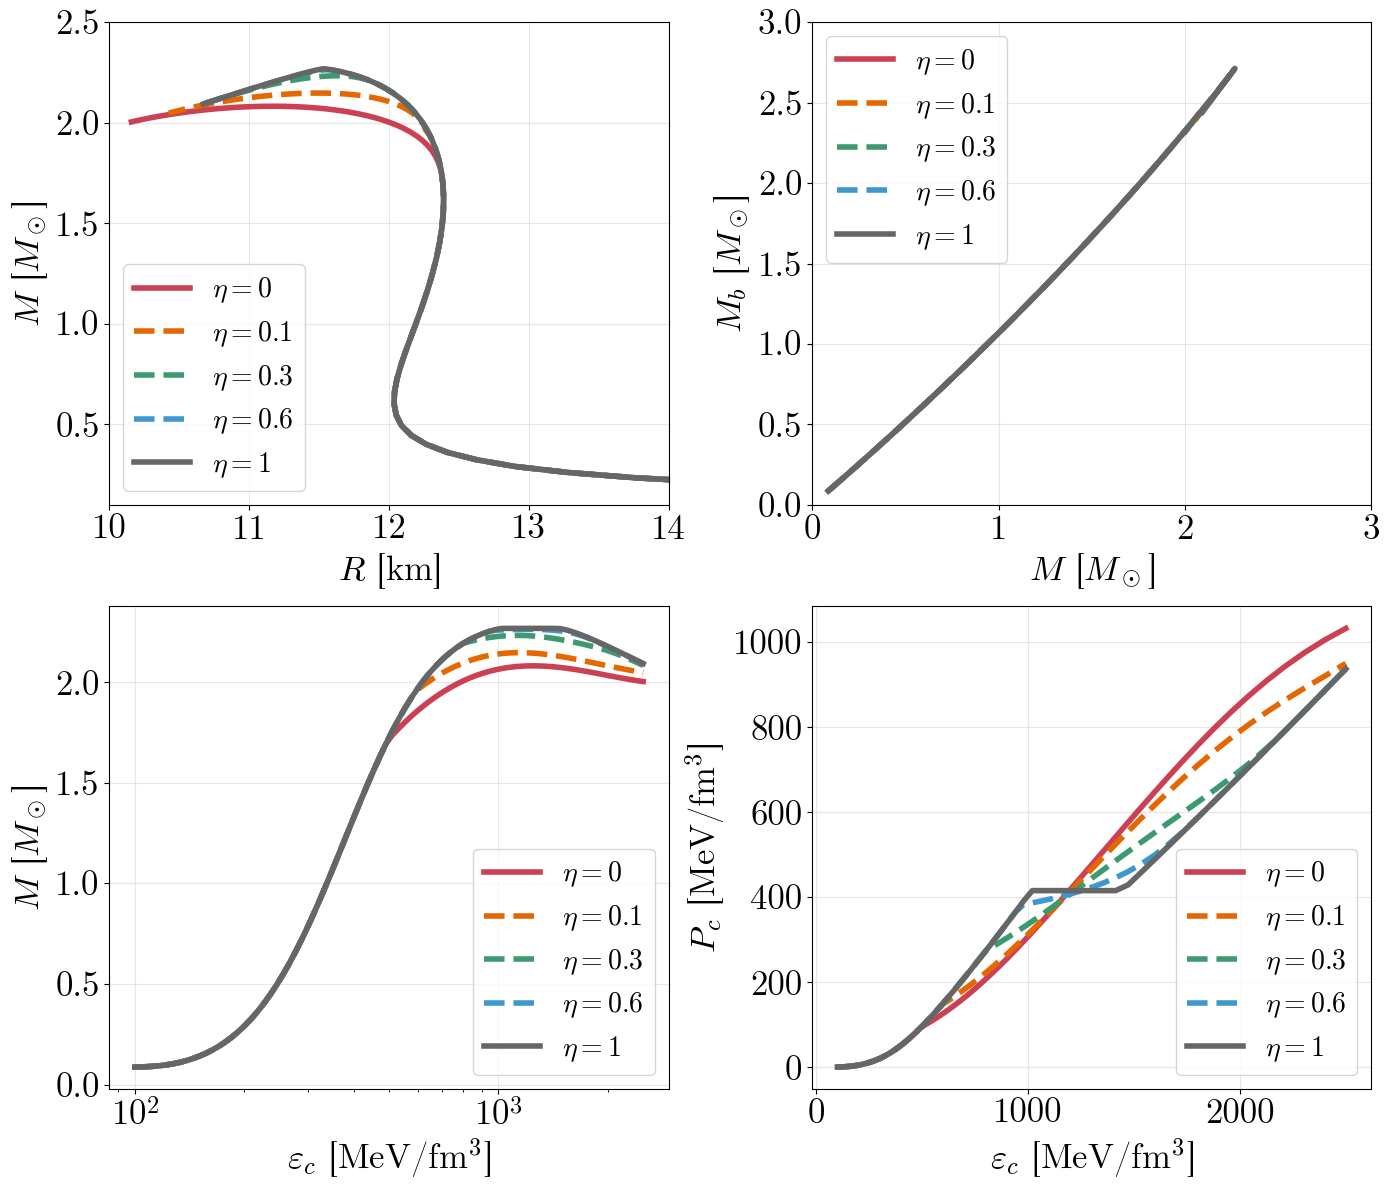


Maximum Mass Summary:
--------------------------------------------------
  η=0.00: M_max = 2.082 M_sun, R = 11.16 km, ε_c = 1251 MeV/fm³
  η=0.10: M_max = 2.148 M_sun, R = 11.48 km, ε_c = 1153 MeV/fm³
  η=0.30: M_max = 2.234 M_sun, R = 11.64 km, ε_c = 1107 MeV/fm³
  η=0.60: M_max = 2.264 M_sun, R = 11.57 km, ε_c = 1201 MeV/fm³
  η=1.00: M_max = 2.269 M_sun, R = 11.54 km, ε_c = 1063 MeV/fm³


In [20]:
# ==============================================================================
# PLOTTING (2x2 layout with P vs ε)
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for eta in eta_values:
    data = tov_results[eta]
    # Columns: e_c, n_c, P_c, R, M, M_b
    e_c, n_c, P_c, R, M, M_b = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5]
    
    style = ETA_STYLES[eta]
    axes[0, 0].plot(R, M, color=style['color'], ls=style['linestyle'], 
                    lw=style['linewidth'], label=style['label'])
    axes[0, 1].plot(M, M_b, color=style['color'], ls=style['linestyle'], 
                    lw=style['linewidth'], label=style['label'])
    axes[1, 0].semilogx(e_c, M, color=style['color'], ls=style['linestyle'], 
                        lw=style['linewidth'], label=style['label'])
    axes[1, 1].plot(e_c, P_c, color=style['color'], ls=style['linestyle'], 
                      lw=style['linewidth'], label=style['label'])

# M-R plot
axes[0, 0].set_xlabel(r'$R$ [km]')
axes[0, 0].set_ylabel(r'$M$ [$M_\odot$]')
axes[0, 0].set_xlim(10, 14)
axes[0, 0].set_ylim(0.1, 2.5)
axes[0, 0].legend(loc='lower left')
axes[0, 0].grid(True, alpha=0.3)

# M vs M_b plot
axes[0, 1].set_xlabel(r'$M$ [$M_\odot$]')
axes[0, 1].set_ylabel(r'$M_b$ [$M_\odot$]')
axes[0, 1].set_xlim(0, 3.0)
axes[0, 1].set_ylim(0, 3.0)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# M vs e_c plot
axes[1, 0].set_xlabel(r'$\varepsilon_c$ [MeV/fm$^3$]')
axes[1, 0].set_ylabel(r'$M$ [$M_\odot$]')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(True, alpha=0.3)

# P vs ε plot (central values)
axes[1, 1].set_xlabel(r'$\varepsilon_c$ [MeV/fm$^3$]')
axes[1, 1].set_ylabel(r'$P_c$ [MeV/fm$^3$]')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTDIR_TOV / 'tov_all_eta_2x2.png', dpi=150, bbox_inches='tight')
plt.show()

# Print M_max summary
print("\nMaximum Mass Summary:")
print("-" * 50)
for eta in eta_values:
    data = tov_results[eta]
    M_max = data[:, 4].max()
    idx = data[:, 4].argmax()
    R_max = data[idx, 3]
    e_c_max = data[idx, 0]
    print(f"  η={eta:.2f}: M_max = {M_max:.3f} M_sun, R = {R_max:.2f} km, ε_c = {e_c_max:.0f} MeV/fm³")
